In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


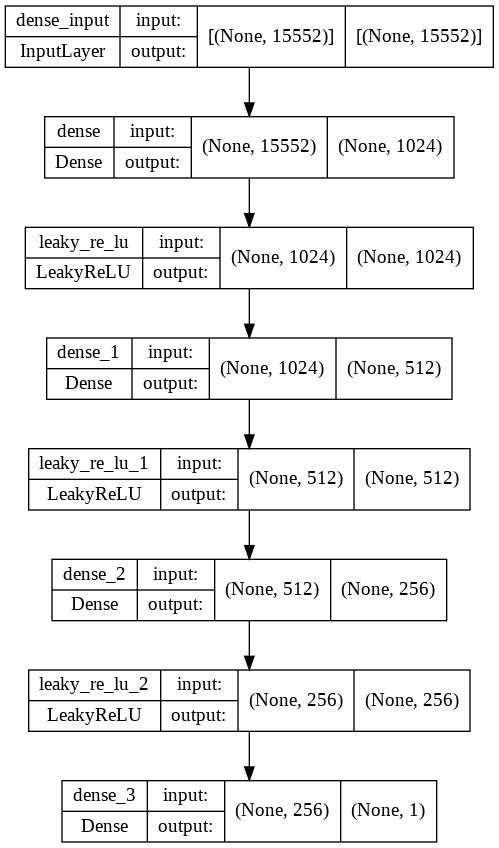

In [3]:
# Building the discriminator model
def build_discriminator(img_shape=(72, 72, 3)):
    model = Sequential()
     
    model.add(Dense(1024, input_dim=72*72*3))
    model.add(LeakyReLU(0.2))

    model.add(Dense(512))
    model.add(LeakyReLU(0.2))

    model.add(Dense(256))
    model.add(LeakyReLU(0.2))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    
    return model

# Build, compile and display a summary of the discriminator
discriminator = build_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=True)

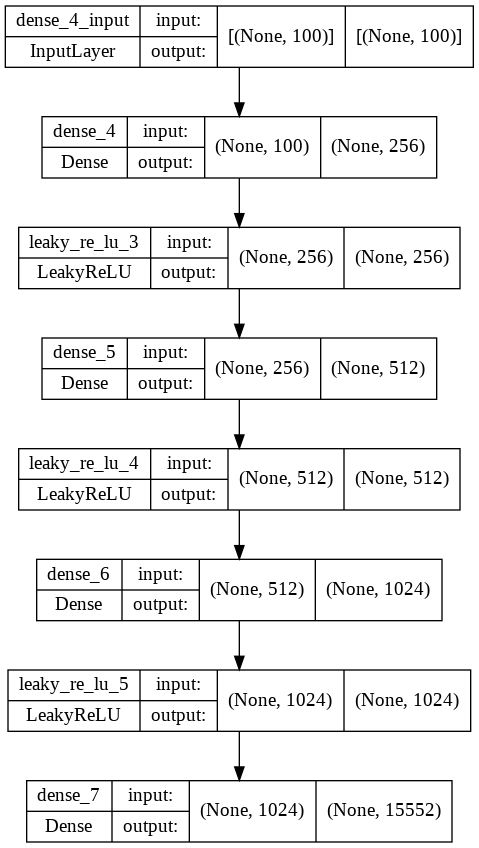

In [4]:
# Building the generator model
def build_generator(latent_dim, img_shape=(72, 72, 3)):

    model = Sequential()
    
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))

    model.add(Dense(512))
    model.add(LeakyReLU(0.2))

    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))

    model.add(Dense(72*72*3, activation='tanh'))
    
    return model

# Size of the latent space
latent_dim = 100
# Build and display a summary of the discriminator
generator = build_generator(latent_dim)
plot_model(generator, show_shapes=True, show_layer_names=True)

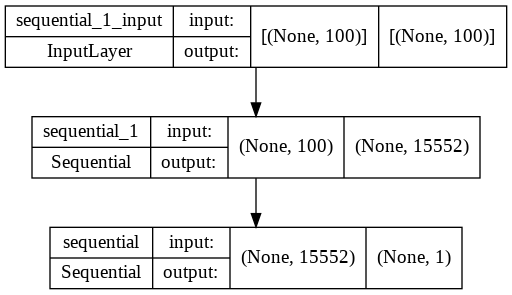

In [5]:
# Building the GAN model which combines the discriminator and generator models
def define_gan(generator, discriminator):
    # Set the weights in the discriminator to not trainable
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # Compile combined GAN model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

    return model

# Build and display a summary of the GAN
gan_model = define_gan(generator, discriminator)
plot_model(gan_model, show_shapes=True, show_layer_names=True)

In [6]:
# Load and return the training data
def load_training_data():
    train_x = np.load(path + 'train_x10000x72.npy', allow_pickle=True)

    # Converting image data from doubles to floats
    train_x = train_x.astype('float32')
    # Scale from [0, 255] to [-1, 1]
    train_x = (train_x - 127.5) / 127.5

    return train_x

In [7]:
# Select random images from training data
def select_real_samples(train_x, n_samples):
    # Choose n_samples amount of random indexes
    random_indexes = np.random.randint(0, train_x.shape[0], n_samples)
    # Select the images from the training data
    real_samples_x = train_x[random_indexes]
    # Label '1' for each image to signify that it is real
    real_samples_y = np.ones((n_samples, 1))

    return real_samples_x, real_samples_y

In [8]:
# Generate random points in the latent space
def generate_latent_points(latent_dim, n_samples):
    # Choose n_samples amount of random points in the latent space
    fake_x_input = np.random.randn(latent_dim * n_samples)
    # Reshape into batches of inputs for the model
    fake_x_input = fake_x_input.reshape(n_samples, latent_dim)

    return fake_x_input

In [9]:
# Generate fake images using random points in the latent space
def generate_fake_samples(generator, latent_dim, n_samples):
    # Generate random points in the latent space
    fake_x_input = generate_latent_points(latent_dim, n_samples)
    # Generate fake images
    fake_x = generator.predict(fake_x_input)
    # Label '0' for each image to signify that it is fake
    fake_y = np.zeros((n_samples, 1))

    return fake_x, fake_y

In [10]:
# Display and save a plot of n^2 generated images
def plot_gen_imgs(generated_imgs, epoch, n=4):
    # Scale from [-1, 1] to [0, 1] for displaying images
    generated_imgs = (generated_imgs + 1) / 2.0

    # Plot generated images in a grid
    fig, ax = plt.subplots(n, n, figsize=(2, 2))
    count = 0
    for i in range(n):
        for j in range(n):
            ax[i, j].imshow(generated_imgs[count])
            ax[i, j].axis('off')
            count += 1
    
    # Save the plot of generated images
    plt.savefig(path + '/FCGAN for 72x72 Output/generated_images_epoch_%d.jpg' % 
                (epoch+1), bbox_inches='tight', dpi = 200)
    plt.close()

In [11]:
# Save the generator model
def save_generator(generator, epoch):
    generator.save(path  + '/FCGAN for 72x72 Output/generator_model_epoch_%d.h5' % 
                   (epoch+1))

In [12]:
losses = []
accuracies = []
epochs = []

# Periodic evaluation of the model
def evaluate_gan(epoch, generator, discriminator, train_x, latent_dim, n_samples=150):
    # Evaluate discriminator on real images
    real_x, real_y = select_real_samples(train_x, n_samples)
    real_x = real_x.reshape(n_samples, 15552)
    _, d_acc_real = discriminator.evaluate(real_x, real_y, verbose=0)

    # Evaluate discriminator on fake images
    fake_x, fake_y = generate_fake_samples(generator, latent_dim, n_samples)
    fake_x = fake_x.reshape(n_samples, 15552)
    _, d_acc_fake = discriminator.evaluate(fake_x, fake_y, verbose=0)

    print('\nDiscriminator Accuracy (Real Data): %.0f%%, Discriminator Accuracy (Fake Data): %.0f%%\n' % 
          (d_acc_real*100, d_acc_fake*100))
    
    fake_x = fake_x.reshape(n_samples, 72, 72, 3)
    plot_gen_imgs(fake_x, epoch)
    save_generator(generator, epoch)

In [13]:
# Display and save plots to show discriminator loss and accuracy throughout training
def plot_loss_and_accuracy(losses, accuracies, epochs):
    losses = np.array(losses)
    accuracies = np.array(accuracies)
    epochs = np.array(epochs)

    # Plot training losses for Discriminator
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, losses.T[0], label='Discriminator Loss (Real Data)')
    plt.plot(epochs, losses.T[1], label='Discriminator Loss (Fake Data)')

    # Calculate line of best fit
    a0, a1 = np.polyfit(epochs, losses.T[0], 1)
    b0, b1 = np.polyfit(epochs, losses.T[1], 1)


    # Plot line of best fit
    plt.plot(epochs, a0*epochs + a1, color='blue', linestyle='dashed', 
              label='Line of best fit Discriminator Loss (Real Data)')
    plt.plot(epochs, b0*epochs + b1, color='red', linestyle='dashed', 
              label='Line of best fit Discriminator Loss (Fake Data)')


    # Configure and save plot
    plt.xticks(np.arange(0, np.max(epochs) + 1, epochs.shape[0] / 20))
    plt.title('Discriminator Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    plt.xlim([0, np.max(epochs) + 1])
    plt.ylim()
    plt.legend()
    plt.savefig(path + '/FCGAN for 72x72 Output/discriminator_loss_plot.jpg', 
                bbox_inches='tight')


    # Plot training accuracies for Discriminator
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, accuracies.T[0], label='Discriminator Accuracy (Real Data)')
    plt.plot(epochs, accuracies.T[1], label='Discriminator Accuracy (Fake Data)')

    # Calculate line of best fit
    d0, d1 = np.polyfit(epochs, accuracies.T[0], 1)
    e0, e1 = np.polyfit(epochs, accuracies.T[1], 1)

    # Plot line of best fit
    plt.plot(epochs, d0*epochs + d1, color='blue', linestyle='dashed', 
              label='Line of best fit (Real Data)')
    plt.plot(epochs, e0*epochs + e1, color='red', linestyle='dashed', 
              label='Line of best fit (Fake Data)')

    # Configure and save plot
    plt.xticks(np.arange(0, np.max(epochs) + 1, epochs.shape[0] / 20))
    plt.title('Discriminator Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Values (%)')
    plt.xlim([0, np.max(epochs) + 1])
    plt.ylim([0, 110])
    plt.legend()
    plt.savefig(path + '/FCGAN for 72x72 Output/discriminator_accuracy_plot.jpg', 
                bbox_inches='tight')

Epoch 1/1000: 100%|██████████| 78/78 [00:10<00:00,  7.23it/s]


Discriminator Loss (Real Data): 0.024, Discriminator Loss (Fake Data): 1.201, Generator Loss: 0.717


Epoch 2/1000: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s]


Discriminator Loss (Real Data): 0.656, Discriminator Loss (Fake Data): 1.767, Generator Loss: 0.309


Epoch 3/1000: 100%|██████████| 78/78 [00:07<00:00, 10.60it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 1.146, Generator Loss: 0.848


Epoch 4/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.359, Discriminator Loss (Fake Data): 0.815, Generator Loss: 1.732


Epoch 5/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 3.599, Discriminator Loss (Fake Data): 3.646, Generator Loss: 0.021


Epoch 6/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.781, Discriminator Loss (Fake Data): 0.969, Generator Loss: 0.883


Epoch 7/1000: 100%|██████████| 78/78 [00:06<00:00, 11.95it/s]


Discriminator Loss (Real Data): 0.754, Discriminator Loss (Fake Data): 0.827, Generator Loss: 0.857


Epoch 8/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.721, Discriminator Loss (Fake Data): 0.741, Generator Loss: 0.822


Epoch 9/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.775, Discriminator Loss (Fake Data): 0.807, Generator Loss: 0.809


Epoch 10/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.730, Discriminator Loss (Fake Data): 0.740, Generator Loss: 0.773

Discriminator Accuracy (Real Data): 2%, Discriminator Accuracy (Fake Data): 100%



Epoch 11/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.755, Discriminator Loss (Fake Data): 0.731, Generator Loss: 0.795


Epoch 12/1000: 100%|██████████| 78/78 [00:07<00:00, 11.03it/s]


Discriminator Loss (Real Data): 0.728, Discriminator Loss (Fake Data): 0.815, Generator Loss: 0.789


Epoch 13/1000: 100%|██████████| 78/78 [00:07<00:00, 11.03it/s]


Discriminator Loss (Real Data): 0.751, Discriminator Loss (Fake Data): 0.791, Generator Loss: 0.868


Epoch 14/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.782, Discriminator Loss (Fake Data): 0.755, Generator Loss: 0.877


Epoch 15/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.459, Discriminator Loss (Fake Data): 0.507, Generator Loss: 1.126


Epoch 16/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.545, Discriminator Loss (Fake Data): 0.620, Generator Loss: 1.036


Epoch 17/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.662, Discriminator Loss (Fake Data): 0.661, Generator Loss: 0.944


Epoch 18/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.650, Discriminator Loss (Fake Data): 0.632, Generator Loss: 1.052


Epoch 19/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.588, Generator Loss: 1.045


Epoch 20/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.027, Discriminator Loss (Fake Data): 0.700, Generator Loss: 1.813

Discriminator Accuracy (Real Data): 0%, Discriminator Accuracy (Fake Data): 100%



Epoch 21/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.796, Generator Loss: 0.980


Epoch 22/1000: 100%|██████████| 78/78 [00:07<00:00, 10.98it/s]


Discriminator Loss (Real Data): 0.642, Discriminator Loss (Fake Data): 0.872, Generator Loss: 1.132


Epoch 23/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.689, Discriminator Loss (Fake Data): 0.684, Generator Loss: 0.925


Epoch 24/1000: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s]


Discriminator Loss (Real Data): 0.677, Discriminator Loss (Fake Data): 0.708, Generator Loss: 0.891


Epoch 25/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.754, Discriminator Loss (Fake Data): 0.610, Generator Loss: 0.937


Epoch 26/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.630, Discriminator Loss (Fake Data): 0.662, Generator Loss: 1.018


Epoch 27/1000: 100%|██████████| 78/78 [00:06<00:00, 11.21it/s]


Discriminator Loss (Real Data): 0.729, Discriminator Loss (Fake Data): 0.633, Generator Loss: 0.959


Epoch 28/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.757, Discriminator Loss (Fake Data): 0.705, Generator Loss: 0.877


Epoch 29/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.661, Discriminator Loss (Fake Data): 0.724, Generator Loss: 0.977


Epoch 30/1000: 100%|██████████| 78/78 [00:06<00:00, 11.89it/s]


Discriminator Loss (Real Data): 0.669, Discriminator Loss (Fake Data): 0.685, Generator Loss: 0.920

Discriminator Accuracy (Real Data): 35%, Discriminator Accuracy (Fake Data): 90%



Epoch 31/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.726, Discriminator Loss (Fake Data): 0.796, Generator Loss: 1.029


Epoch 32/1000: 100%|██████████| 78/78 [00:07<00:00, 10.95it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.664, Generator Loss: 1.237


Epoch 33/1000: 100%|██████████| 78/78 [00:07<00:00, 11.07it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.655, Generator Loss: 1.032


Epoch 34/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.647, Discriminator Loss (Fake Data): 0.748, Generator Loss: 1.072


Epoch 35/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.825, Discriminator Loss (Fake Data): 0.691, Generator Loss: 1.136


Epoch 36/1000: 100%|██████████| 78/78 [00:06<00:00, 11.21it/s]


Discriminator Loss (Real Data): 0.629, Discriminator Loss (Fake Data): 0.721, Generator Loss: 1.055


Epoch 37/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.675, Generator Loss: 1.092


Epoch 38/1000: 100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Discriminator Loss (Real Data): 0.706, Discriminator Loss (Fake Data): 0.549, Generator Loss: 1.073


Epoch 39/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.756, Generator Loss: 1.007


Epoch 40/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.686, Discriminator Loss (Fake Data): 0.639, Generator Loss: 1.003

Discriminator Accuracy (Real Data): 66%, Discriminator Accuracy (Fake Data): 87%



Epoch 41/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.675, Discriminator Loss (Fake Data): 0.546, Generator Loss: 1.117


Epoch 42/1000: 100%|██████████| 78/78 [00:06<00:00, 11.23it/s]


Discriminator Loss (Real Data): 0.624, Discriminator Loss (Fake Data): 0.712, Generator Loss: 1.189


Epoch 43/1000: 100%|██████████| 78/78 [00:07<00:00, 11.10it/s]


Discriminator Loss (Real Data): 0.561, Discriminator Loss (Fake Data): 0.583, Generator Loss: 1.164


Epoch 44/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.661, Generator Loss: 1.209


Epoch 45/1000: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s]


Discriminator Loss (Real Data): 0.614, Discriminator Loss (Fake Data): 0.754, Generator Loss: 1.437


Epoch 46/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.714, Discriminator Loss (Fake Data): 0.729, Generator Loss: 1.146


Epoch 47/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.818, Discriminator Loss (Fake Data): 0.678, Generator Loss: 1.089


Epoch 48/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.638, Discriminator Loss (Fake Data): 0.686, Generator Loss: 1.166


Epoch 49/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.581, Discriminator Loss (Fake Data): 0.691, Generator Loss: 1.074


Epoch 50/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.667, Discriminator Loss (Fake Data): 0.715, Generator Loss: 1.220

Discriminator Accuracy (Real Data): 36%, Discriminator Accuracy (Fake Data): 79%



Epoch 51/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.810, Discriminator Loss (Fake Data): 0.696, Generator Loss: 1.183


Epoch 52/1000: 100%|██████████| 78/78 [00:07<00:00, 10.96it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.619, Generator Loss: 1.086


Epoch 53/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.635, Generator Loss: 0.991


Epoch 54/1000: 100%|██████████| 78/78 [00:07<00:00, 10.99it/s]


Discriminator Loss (Real Data): 0.766, Discriminator Loss (Fake Data): 0.716, Generator Loss: 1.147


Epoch 55/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 0.815, Discriminator Loss (Fake Data): 0.684, Generator Loss: 1.149


Epoch 56/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.673, Discriminator Loss (Fake Data): 0.734, Generator Loss: 1.141


Epoch 57/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.650, Discriminator Loss (Fake Data): 0.851, Generator Loss: 1.046


Epoch 58/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.678, Discriminator Loss (Fake Data): 0.648, Generator Loss: 0.974


Epoch 59/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.736, Discriminator Loss (Fake Data): 0.622, Generator Loss: 0.945


Epoch 60/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.825, Discriminator Loss (Fake Data): 0.710, Generator Loss: 1.071

Discriminator Accuracy (Real Data): 44%, Discriminator Accuracy (Fake Data): 89%



Epoch 61/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.626, Discriminator Loss (Fake Data): 0.713, Generator Loss: 1.041


Epoch 62/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.581, Discriminator Loss (Fake Data): 0.678, Generator Loss: 1.060


Epoch 63/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.648, Discriminator Loss (Fake Data): 0.724, Generator Loss: 1.094


Epoch 64/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.651, Discriminator Loss (Fake Data): 0.847, Generator Loss: 1.015


Epoch 65/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.759, Discriminator Loss (Fake Data): 0.677, Generator Loss: 0.938


Epoch 66/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.648, Generator Loss: 1.021


Epoch 67/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.824, Discriminator Loss (Fake Data): 0.605, Generator Loss: 1.135


Epoch 68/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.710, Discriminator Loss (Fake Data): 0.675, Generator Loss: 1.064


Epoch 69/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.738, Discriminator Loss (Fake Data): 0.723, Generator Loss: 0.967


Epoch 70/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.707, Discriminator Loss (Fake Data): 0.726, Generator Loss: 1.000

Discriminator Accuracy (Real Data): 39%, Discriminator Accuracy (Fake Data): 89%



Epoch 71/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.598, Generator Loss: 1.052


Epoch 72/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.717, Discriminator Loss (Fake Data): 0.625, Generator Loss: 1.013


Epoch 73/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.741, Discriminator Loss (Fake Data): 0.574, Generator Loss: 1.071


Epoch 74/1000: 100%|██████████| 78/78 [00:06<00:00, 11.82it/s]


Discriminator Loss (Real Data): 0.664, Discriminator Loss (Fake Data): 0.771, Generator Loss: 1.117


Epoch 75/1000: 100%|██████████| 78/78 [00:06<00:00, 11.90it/s]


Discriminator Loss (Real Data): 0.710, Discriminator Loss (Fake Data): 0.692, Generator Loss: 1.020


Epoch 76/1000: 100%|██████████| 78/78 [00:06<00:00, 11.94it/s]


Discriminator Loss (Real Data): 0.711, Discriminator Loss (Fake Data): 0.713, Generator Loss: 0.982


Epoch 77/1000: 100%|██████████| 78/78 [00:06<00:00, 12.03it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.739, Generator Loss: 1.085


Epoch 78/1000: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s]


Discriminator Loss (Real Data): 0.740, Discriminator Loss (Fake Data): 0.667, Generator Loss: 0.998


Epoch 79/1000: 100%|██████████| 78/78 [00:07<00:00, 10.97it/s]


Discriminator Loss (Real Data): 0.749, Discriminator Loss (Fake Data): 0.657, Generator Loss: 0.952


Epoch 80/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.710, Discriminator Loss (Fake Data): 0.716, Generator Loss: 1.079

Discriminator Accuracy (Real Data): 49%, Discriminator Accuracy (Fake Data): 87%



Epoch 81/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.657, Discriminator Loss (Fake Data): 0.661, Generator Loss: 0.994


Epoch 82/1000: 100%|██████████| 78/78 [00:06<00:00, 11.14it/s]


Discriminator Loss (Real Data): 0.658, Discriminator Loss (Fake Data): 0.641, Generator Loss: 1.020


Epoch 83/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.690, Discriminator Loss (Fake Data): 0.624, Generator Loss: 1.088


Epoch 84/1000: 100%|██████████| 78/78 [00:06<00:00, 11.89it/s]


Discriminator Loss (Real Data): 0.714, Discriminator Loss (Fake Data): 0.781, Generator Loss: 1.117


Epoch 85/1000: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 0.646, Generator Loss: 1.050


Epoch 86/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.766, Discriminator Loss (Fake Data): 0.633, Generator Loss: 1.024


Epoch 87/1000: 100%|██████████| 78/78 [00:06<00:00, 11.79it/s]


Discriminator Loss (Real Data): 0.748, Discriminator Loss (Fake Data): 0.711, Generator Loss: 0.971


Epoch 88/1000: 100%|██████████| 78/78 [00:06<00:00, 11.84it/s]


Discriminator Loss (Real Data): 0.702, Discriminator Loss (Fake Data): 0.646, Generator Loss: 0.982


Epoch 89/1000: 100%|██████████| 78/78 [00:06<00:00, 11.94it/s]


Discriminator Loss (Real Data): 0.726, Discriminator Loss (Fake Data): 0.707, Generator Loss: 0.925


Epoch 90/1000: 100%|██████████| 78/78 [00:06<00:00, 11.92it/s]


Discriminator Loss (Real Data): 0.742, Discriminator Loss (Fake Data): 0.753, Generator Loss: 1.011

Discriminator Accuracy (Real Data): 34%, Discriminator Accuracy (Fake Data): 89%



Epoch 91/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.729, Discriminator Loss (Fake Data): 0.635, Generator Loss: 0.985


Epoch 92/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.655, Discriminator Loss (Fake Data): 0.634, Generator Loss: 1.005


Epoch 93/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.696, Discriminator Loss (Fake Data): 0.710, Generator Loss: 1.016


Epoch 94/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 0.722, Discriminator Loss (Fake Data): 0.711, Generator Loss: 0.984


Epoch 95/1000: 100%|██████████| 78/78 [00:06<00:00, 11.72it/s]


Discriminator Loss (Real Data): 0.718, Discriminator Loss (Fake Data): 0.746, Generator Loss: 1.138


Epoch 96/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 0.728, Discriminator Loss (Fake Data): 0.639, Generator Loss: 1.051


Epoch 97/1000: 100%|██████████| 78/78 [00:06<00:00, 11.97it/s]


Discriminator Loss (Real Data): 0.710, Discriminator Loss (Fake Data): 0.662, Generator Loss: 1.064


Epoch 98/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.712, Discriminator Loss (Fake Data): 0.657, Generator Loss: 1.058


Epoch 99/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.668, Discriminator Loss (Fake Data): 0.726, Generator Loss: 0.985


Epoch 100/1000: 100%|██████████| 78/78 [00:06<00:00, 11.96it/s]


Discriminator Loss (Real Data): 0.674, Discriminator Loss (Fake Data): 0.654, Generator Loss: 1.057

Discriminator Accuracy (Real Data): 49%, Discriminator Accuracy (Fake Data): 82%



Epoch 101/1000: 100%|██████████| 78/78 [00:06<00:00, 11.76it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.819, Generator Loss: 1.192


Epoch 102/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.699, Generator Loss: 1.204


Epoch 103/1000: 100%|██████████| 78/78 [00:06<00:00, 11.97it/s]


Discriminator Loss (Real Data): 0.684, Discriminator Loss (Fake Data): 0.644, Generator Loss: 1.018


Epoch 104/1000: 100%|██████████| 78/78 [00:06<00:00, 11.72it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.722, Generator Loss: 1.027


Epoch 105/1000: 100%|██████████| 78/78 [00:07<00:00, 11.12it/s]


Discriminator Loss (Real Data): 0.668, Discriminator Loss (Fake Data): 0.640, Generator Loss: 0.947


Epoch 106/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.718, Discriminator Loss (Fake Data): 0.631, Generator Loss: 1.032


Epoch 107/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.663, Generator Loss: 0.992


Epoch 108/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.663, Discriminator Loss (Fake Data): 0.629, Generator Loss: 0.986


Epoch 109/1000: 100%|██████████| 78/78 [00:06<00:00, 11.77it/s]


Discriminator Loss (Real Data): 0.683, Discriminator Loss (Fake Data): 0.659, Generator Loss: 0.996


Epoch 110/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.742, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.057

Discriminator Accuracy (Real Data): 25%, Discriminator Accuracy (Fake Data): 88%



Epoch 111/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.771, Discriminator Loss (Fake Data): 0.638, Generator Loss: 1.010


Epoch 112/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.693, Discriminator Loss (Fake Data): 0.643, Generator Loss: 1.046


Epoch 113/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.644, Discriminator Loss (Fake Data): 0.699, Generator Loss: 1.062


Epoch 114/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.730, Discriminator Loss (Fake Data): 0.668, Generator Loss: 1.006


Epoch 115/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.027


Epoch 116/1000: 100%|██████████| 78/78 [00:06<00:00, 11.30it/s]


Discriminator Loss (Real Data): 0.810, Discriminator Loss (Fake Data): 0.654, Generator Loss: 1.052


Epoch 117/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.707, Discriminator Loss (Fake Data): 0.759, Generator Loss: 0.910


Epoch 118/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.660, Discriminator Loss (Fake Data): 0.667, Generator Loss: 1.013


Epoch 119/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.671, Discriminator Loss (Fake Data): 0.674, Generator Loss: 1.011


Epoch 120/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.655, Discriminator Loss (Fake Data): 0.706, Generator Loss: 0.977

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 83%



Epoch 121/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.586, Discriminator Loss (Fake Data): 0.623, Generator Loss: 1.094


Epoch 122/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.640, Discriminator Loss (Fake Data): 0.727, Generator Loss: 1.057


Epoch 123/1000: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s]


Discriminator Loss (Real Data): 0.630, Discriminator Loss (Fake Data): 0.612, Generator Loss: 1.031


Epoch 124/1000: 100%|██████████| 78/78 [00:06<00:00, 11.50it/s]


Discriminator Loss (Real Data): 0.677, Discriminator Loss (Fake Data): 0.680, Generator Loss: 0.949


Epoch 125/1000: 100%|██████████| 78/78 [00:07<00:00, 10.55it/s]


Discriminator Loss (Real Data): 0.720, Discriminator Loss (Fake Data): 0.752, Generator Loss: 1.037


Epoch 126/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.668, Discriminator Loss (Fake Data): 0.906, Generator Loss: 1.178


Epoch 127/1000: 100%|██████████| 78/78 [00:06<00:00, 11.82it/s]


Discriminator Loss (Real Data): 0.635, Discriminator Loss (Fake Data): 0.663, Generator Loss: 1.068


Epoch 128/1000: 100%|██████████| 78/78 [00:06<00:00, 11.21it/s]


Discriminator Loss (Real Data): 0.724, Discriminator Loss (Fake Data): 0.603, Generator Loss: 1.182


Epoch 129/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.676, Discriminator Loss (Fake Data): 0.666, Generator Loss: 0.992


Epoch 130/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.763, Discriminator Loss (Fake Data): 0.762, Generator Loss: 1.058

Discriminator Accuracy (Real Data): 47%, Discriminator Accuracy (Fake Data): 85%



Epoch 131/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.705, Discriminator Loss (Fake Data): 0.749, Generator Loss: 1.111


Epoch 132/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.704, Discriminator Loss (Fake Data): 0.616, Generator Loss: 1.007


Epoch 133/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.737, Discriminator Loss (Fake Data): 0.712, Generator Loss: 1.043


Epoch 134/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.771, Discriminator Loss (Fake Data): 0.720, Generator Loss: 1.015


Epoch 135/1000: 100%|██████████| 78/78 [00:07<00:00, 10.94it/s]


Discriminator Loss (Real Data): 0.732, Discriminator Loss (Fake Data): 0.616, Generator Loss: 1.076


Epoch 136/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.676, Discriminator Loss (Fake Data): 0.613, Generator Loss: 1.006


Epoch 137/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.725, Generator Loss: 0.996


Epoch 138/1000: 100%|██████████| 78/78 [00:06<00:00, 11.84it/s]


Discriminator Loss (Real Data): 0.669, Discriminator Loss (Fake Data): 0.680, Generator Loss: 1.082


Epoch 139/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.553, Discriminator Loss (Fake Data): 0.722, Generator Loss: 1.093


Epoch 140/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.633, Discriminator Loss (Fake Data): 0.669, Generator Loss: 0.992

Discriminator Accuracy (Real Data): 53%, Discriminator Accuracy (Fake Data): 87%



Epoch 141/1000: 100%|██████████| 78/78 [00:06<00:00, 11.87it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.642, Generator Loss: 0.981


Epoch 142/1000: 100%|██████████| 78/78 [00:06<00:00, 11.23it/s]


Discriminator Loss (Real Data): 0.679, Discriminator Loss (Fake Data): 0.666, Generator Loss: 0.996


Epoch 143/1000: 100%|██████████| 78/78 [00:06<00:00, 11.88it/s]


Discriminator Loss (Real Data): 0.672, Discriminator Loss (Fake Data): 0.670, Generator Loss: 1.118


Epoch 144/1000: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s]


Discriminator Loss (Real Data): 0.698, Discriminator Loss (Fake Data): 0.753, Generator Loss: 0.943


Epoch 145/1000: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s]


Discriminator Loss (Real Data): 0.685, Discriminator Loss (Fake Data): 0.645, Generator Loss: 1.025


Epoch 146/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.622, Generator Loss: 0.961


Epoch 147/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.756, Discriminator Loss (Fake Data): 0.678, Generator Loss: 0.994


Epoch 148/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.639, Generator Loss: 1.018


Epoch 149/1000: 100%|██████████| 78/78 [00:06<00:00, 11.87it/s]


Discriminator Loss (Real Data): 0.663, Discriminator Loss (Fake Data): 0.685, Generator Loss: 0.984


Epoch 150/1000: 100%|██████████| 78/78 [00:06<00:00, 11.84it/s]


Discriminator Loss (Real Data): 0.705, Discriminator Loss (Fake Data): 0.612, Generator Loss: 1.055

Discriminator Accuracy (Real Data): 48%, Discriminator Accuracy (Fake Data): 83%



Epoch 151/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.674, Discriminator Loss (Fake Data): 0.622, Generator Loss: 1.049


Epoch 152/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.707, Generator Loss: 1.066


Epoch 153/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.653, Discriminator Loss (Fake Data): 0.670, Generator Loss: 0.953


Epoch 154/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.544, Discriminator Loss (Fake Data): 0.645, Generator Loss: 1.101


Epoch 155/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.670, Discriminator Loss (Fake Data): 0.641, Generator Loss: 1.083


Epoch 156/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.673, Generator Loss: 1.095


Epoch 157/1000: 100%|██████████| 78/78 [00:07<00:00, 10.95it/s]


Discriminator Loss (Real Data): 0.670, Discriminator Loss (Fake Data): 0.584, Generator Loss: 1.092


Epoch 158/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.885, Discriminator Loss (Fake Data): 0.642, Generator Loss: 1.022


Epoch 159/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.648, Discriminator Loss (Fake Data): 0.756, Generator Loss: 1.188


Epoch 160/1000: 100%|██████████| 78/78 [00:06<00:00, 11.76it/s]


Discriminator Loss (Real Data): 0.680, Discriminator Loss (Fake Data): 0.643, Generator Loss: 0.911

Discriminator Accuracy (Real Data): 68%, Discriminator Accuracy (Fake Data): 74%



Epoch 161/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.501, Discriminator Loss (Fake Data): 0.688, Generator Loss: 1.238


Epoch 162/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.664, Discriminator Loss (Fake Data): 0.636, Generator Loss: 1.099


Epoch 163/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.659, Discriminator Loss (Fake Data): 0.640, Generator Loss: 1.025


Epoch 164/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.630, Discriminator Loss (Fake Data): 0.684, Generator Loss: 1.160


Epoch 165/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.644, Discriminator Loss (Fake Data): 0.610, Generator Loss: 1.021


Epoch 166/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.708, Discriminator Loss (Fake Data): 0.750, Generator Loss: 0.983


Epoch 167/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.689, Discriminator Loss (Fake Data): 0.601, Generator Loss: 1.115


Epoch 168/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.645, Discriminator Loss (Fake Data): 0.761, Generator Loss: 1.085


Epoch 169/1000: 100%|██████████| 78/78 [00:06<00:00, 11.92it/s]


Discriminator Loss (Real Data): 0.689, Discriminator Loss (Fake Data): 0.604, Generator Loss: 1.178


Epoch 170/1000: 100%|██████████| 78/78 [00:07<00:00, 10.59it/s]


Discriminator Loss (Real Data): 0.752, Discriminator Loss (Fake Data): 0.658, Generator Loss: 1.119

Discriminator Accuracy (Real Data): 53%, Discriminator Accuracy (Fake Data): 60%



Epoch 171/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.619, Discriminator Loss (Fake Data): 0.618, Generator Loss: 1.228


Epoch 172/1000: 100%|██████████| 78/78 [00:07<00:00, 10.87it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.682, Generator Loss: 0.977


Epoch 173/1000: 100%|██████████| 78/78 [00:06<00:00, 11.25it/s]


Discriminator Loss (Real Data): 0.681, Discriminator Loss (Fake Data): 0.649, Generator Loss: 1.169


Epoch 174/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.661, Generator Loss: 1.151


Epoch 175/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.660, Discriminator Loss (Fake Data): 0.700, Generator Loss: 0.973


Epoch 176/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.636, Generator Loss: 0.969


Epoch 177/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.577, Discriminator Loss (Fake Data): 0.675, Generator Loss: 1.092


Epoch 178/1000: 100%|██████████| 78/78 [00:07<00:00, 11.01it/s]


Discriminator Loss (Real Data): 0.758, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.169


Epoch 179/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.635, Discriminator Loss (Fake Data): 0.695, Generator Loss: 0.934


Epoch 180/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.688, Generator Loss: 0.991

Discriminator Accuracy (Real Data): 65%, Discriminator Accuracy (Fake Data): 87%



Epoch 181/1000: 100%|██████████| 78/78 [00:06<00:00, 11.50it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.669, Generator Loss: 1.181


Epoch 182/1000: 100%|██████████| 78/78 [00:06<00:00, 11.18it/s]


Discriminator Loss (Real Data): 0.697, Discriminator Loss (Fake Data): 0.644, Generator Loss: 1.055


Epoch 183/1000: 100%|██████████| 78/78 [00:06<00:00, 11.82it/s]


Discriminator Loss (Real Data): 0.596, Discriminator Loss (Fake Data): 0.647, Generator Loss: 0.998


Epoch 184/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.661, Discriminator Loss (Fake Data): 0.695, Generator Loss: 0.996


Epoch 185/1000: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s]


Discriminator Loss (Real Data): 0.763, Discriminator Loss (Fake Data): 0.672, Generator Loss: 1.451


Epoch 186/1000: 100%|██████████| 78/78 [00:06<00:00, 11.86it/s]


Discriminator Loss (Real Data): 0.584, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.024


Epoch 187/1000: 100%|██████████| 78/78 [00:07<00:00, 10.92it/s]


Discriminator Loss (Real Data): 0.671, Discriminator Loss (Fake Data): 0.672, Generator Loss: 1.037


Epoch 188/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.606, Discriminator Loss (Fake Data): 0.651, Generator Loss: 1.083


Epoch 189/1000: 100%|██████████| 78/78 [00:06<00:00, 11.76it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.695, Generator Loss: 1.102


Epoch 190/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.656, Discriminator Loss (Fake Data): 0.649, Generator Loss: 1.030

Discriminator Accuracy (Real Data): 48%, Discriminator Accuracy (Fake Data): 91%



Epoch 191/1000: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s]


Discriminator Loss (Real Data): 0.593, Discriminator Loss (Fake Data): 0.671, Generator Loss: 1.060


Epoch 192/1000: 100%|██████████| 78/78 [00:06<00:00, 11.82it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.014


Epoch 193/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.759, Discriminator Loss (Fake Data): 0.613, Generator Loss: 1.096


Epoch 194/1000: 100%|██████████| 78/78 [00:06<00:00, 12.00it/s]


Discriminator Loss (Real Data): 0.685, Discriminator Loss (Fake Data): 0.656, Generator Loss: 1.175


Epoch 195/1000: 100%|██████████| 78/78 [00:06<00:00, 12.00it/s]


Discriminator Loss (Real Data): 0.684, Discriminator Loss (Fake Data): 0.688, Generator Loss: 1.049


Epoch 196/1000: 100%|██████████| 78/78 [00:06<00:00, 11.93it/s]


Discriminator Loss (Real Data): 0.655, Discriminator Loss (Fake Data): 0.642, Generator Loss: 0.973


Epoch 197/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.844, Discriminator Loss (Fake Data): 0.668, Generator Loss: 0.920


Epoch 198/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.585, Generator Loss: 1.045


Epoch 199/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.609, Discriminator Loss (Fake Data): 0.646, Generator Loss: 0.993


Epoch 200/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.602, Generator Loss: 0.968

Discriminator Accuracy (Real Data): 53%, Discriminator Accuracy (Fake Data): 80%



Epoch 201/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 0.693, Discriminator Loss (Fake Data): 0.628, Generator Loss: 0.988


Epoch 202/1000: 100%|██████████| 78/78 [00:07<00:00, 10.98it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.697, Generator Loss: 1.136


Epoch 203/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.674, Discriminator Loss (Fake Data): 0.641, Generator Loss: 0.968


Epoch 204/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.676, Discriminator Loss (Fake Data): 0.631, Generator Loss: 0.974


Epoch 205/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.596, Discriminator Loss (Fake Data): 0.671, Generator Loss: 1.026


Epoch 206/1000: 100%|██████████| 78/78 [00:07<00:00, 10.72it/s]


Discriminator Loss (Real Data): 0.655, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.084


Epoch 207/1000: 100%|██████████| 78/78 [00:06<00:00, 11.14it/s]


Discriminator Loss (Real Data): 0.726, Discriminator Loss (Fake Data): 0.643, Generator Loss: 0.981


Epoch 208/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.560, Discriminator Loss (Fake Data): 0.828, Generator Loss: 1.288


Epoch 209/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.545, Discriminator Loss (Fake Data): 0.606, Generator Loss: 1.067


Epoch 210/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.922, Discriminator Loss (Fake Data): 0.643, Generator Loss: 1.103

Discriminator Accuracy (Real Data): 47%, Discriminator Accuracy (Fake Data): 75%



Epoch 211/1000: 100%|██████████| 78/78 [00:07<00:00, 10.92it/s]


Discriminator Loss (Real Data): 0.527, Discriminator Loss (Fake Data): 0.685, Generator Loss: 1.064


Epoch 212/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.605, Discriminator Loss (Fake Data): 0.653, Generator Loss: 1.040


Epoch 213/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.650, Discriminator Loss (Fake Data): 0.663, Generator Loss: 0.954


Epoch 214/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.660, Discriminator Loss (Fake Data): 0.696, Generator Loss: 1.051


Epoch 215/1000: 100%|██████████| 78/78 [00:06<00:00, 11.16it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.619, Generator Loss: 1.049


Epoch 216/1000: 100%|██████████| 78/78 [00:06<00:00, 11.93it/s]


Discriminator Loss (Real Data): 0.635, Discriminator Loss (Fake Data): 0.603, Generator Loss: 1.008


Epoch 217/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.067


Epoch 218/1000: 100%|██████████| 78/78 [00:06<00:00, 11.92it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.698, Generator Loss: 1.091


Epoch 219/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.529, Discriminator Loss (Fake Data): 0.662, Generator Loss: 1.149


Epoch 220/1000: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s]


Discriminator Loss (Real Data): 0.516, Discriminator Loss (Fake Data): 0.760, Generator Loss: 1.159

Discriminator Accuracy (Real Data): 43%, Discriminator Accuracy (Fake Data): 84%



Epoch 221/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.655, Discriminator Loss (Fake Data): 0.662, Generator Loss: 0.951


Epoch 222/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.530, Discriminator Loss (Fake Data): 0.729, Generator Loss: 1.009


Epoch 223/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.611, Generator Loss: 1.017


Epoch 224/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.700, Discriminator Loss (Fake Data): 0.660, Generator Loss: 1.162


Epoch 225/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.791, Discriminator Loss (Fake Data): 0.788, Generator Loss: 0.912


Epoch 226/1000: 100%|██████████| 78/78 [00:06<00:00, 11.95it/s]


Discriminator Loss (Real Data): 0.611, Discriminator Loss (Fake Data): 0.701, Generator Loss: 1.009


Epoch 227/1000: 100%|██████████| 78/78 [00:07<00:00, 10.70it/s]


Discriminator Loss (Real Data): 0.684, Discriminator Loss (Fake Data): 0.554, Generator Loss: 1.040


Epoch 228/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.594, Discriminator Loss (Fake Data): 0.637, Generator Loss: 0.974


Epoch 229/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.617, Generator Loss: 1.038


Epoch 230/1000: 100%|██████████| 78/78 [00:06<00:00, 12.00it/s]


Discriminator Loss (Real Data): 0.809, Discriminator Loss (Fake Data): 0.657, Generator Loss: 1.465

Discriminator Accuracy (Real Data): 27%, Discriminator Accuracy (Fake Data): 90%



Epoch 231/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.720, Discriminator Loss (Fake Data): 0.709, Generator Loss: 1.068


Epoch 232/1000: 100%|██████████| 78/78 [00:06<00:00, 11.18it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.647, Generator Loss: 1.535


Epoch 233/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.725, Discriminator Loss (Fake Data): 0.685, Generator Loss: 1.092


Epoch 234/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.716, Generator Loss: 1.011


Epoch 235/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.656, Generator Loss: 0.974


Epoch 236/1000: 100%|██████████| 78/78 [00:06<00:00, 11.99it/s]


Discriminator Loss (Real Data): 0.694, Discriminator Loss (Fake Data): 0.672, Generator Loss: 1.060


Epoch 237/1000: 100%|██████████| 78/78 [00:07<00:00, 11.05it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.669, Generator Loss: 1.212


Epoch 238/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.644, Discriminator Loss (Fake Data): 0.715, Generator Loss: 1.106


Epoch 239/1000: 100%|██████████| 78/78 [00:06<00:00, 12.03it/s]


Discriminator Loss (Real Data): 0.649, Discriminator Loss (Fake Data): 0.666, Generator Loss: 1.100


Epoch 240/1000: 100%|██████████| 78/78 [00:06<00:00, 11.85it/s]


Discriminator Loss (Real Data): 0.691, Discriminator Loss (Fake Data): 0.619, Generator Loss: 1.029

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 81%



Epoch 241/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.673, Discriminator Loss (Fake Data): 0.699, Generator Loss: 1.026


Epoch 242/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.631, Discriminator Loss (Fake Data): 0.703, Generator Loss: 0.972


Epoch 243/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.618, Discriminator Loss (Fake Data): 0.712, Generator Loss: 1.068


Epoch 244/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.577, Discriminator Loss (Fake Data): 0.621, Generator Loss: 1.026


Epoch 245/1000: 100%|██████████| 78/78 [00:06<00:00, 11.95it/s]


Discriminator Loss (Real Data): 0.590, Discriminator Loss (Fake Data): 0.758, Generator Loss: 1.058


Epoch 246/1000: 100%|██████████| 78/78 [00:06<00:00, 11.82it/s]


Discriminator Loss (Real Data): 0.667, Discriminator Loss (Fake Data): 0.762, Generator Loss: 1.032


Epoch 247/1000: 100%|██████████| 78/78 [00:06<00:00, 11.77it/s]


Discriminator Loss (Real Data): 0.691, Discriminator Loss (Fake Data): 0.671, Generator Loss: 1.041


Epoch 248/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.523, Discriminator Loss (Fake Data): 0.638, Generator Loss: 1.031


Epoch 249/1000: 100%|██████████| 78/78 [00:07<00:00, 10.38it/s]


Discriminator Loss (Real Data): 0.490, Discriminator Loss (Fake Data): 0.639, Generator Loss: 1.076


Epoch 250/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.819, Discriminator Loss (Fake Data): 0.685, Generator Loss: 1.013

Discriminator Accuracy (Real Data): 63%, Discriminator Accuracy (Fake Data): 81%



Epoch 251/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.597, Generator Loss: 1.057


Epoch 252/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.593, Discriminator Loss (Fake Data): 0.638, Generator Loss: 1.009


Epoch 253/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.634, Generator Loss: 1.047


Epoch 254/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.553, Discriminator Loss (Fake Data): 0.570, Generator Loss: 1.126


Epoch 255/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.484, Discriminator Loss (Fake Data): 0.700, Generator Loss: 1.050


Epoch 256/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.489, Discriminator Loss (Fake Data): 0.600, Generator Loss: 1.025


Epoch 257/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 1.596, Discriminator Loss (Fake Data): 1.393, Generator Loss: 1.788


Epoch 258/1000: 100%|██████████| 78/78 [00:06<00:00, 11.81it/s]


Discriminator Loss (Real Data): 0.663, Discriminator Loss (Fake Data): 0.705, Generator Loss: 0.884


Epoch 259/1000: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s]


Discriminator Loss (Real Data): 0.635, Discriminator Loss (Fake Data): 0.675, Generator Loss: 0.935


Epoch 260/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.748, Discriminator Loss (Fake Data): 0.622, Generator Loss: 0.924

Discriminator Accuracy (Real Data): 63%, Discriminator Accuracy (Fake Data): 73%



Epoch 261/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 0.696, Discriminator Loss (Fake Data): 0.571, Generator Loss: 0.927


Epoch 262/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.688, Discriminator Loss (Fake Data): 0.618, Generator Loss: 1.033


Epoch 263/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.671, Discriminator Loss (Fake Data): 0.632, Generator Loss: 0.961


Epoch 264/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.482, Discriminator Loss (Fake Data): 0.597, Generator Loss: 0.996


Epoch 265/1000: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s]


Discriminator Loss (Real Data): 0.534, Discriminator Loss (Fake Data): 0.614, Generator Loss: 0.941


Epoch 266/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.527, Discriminator Loss (Fake Data): 0.810, Generator Loss: 1.040


Epoch 267/1000: 100%|██████████| 78/78 [00:06<00:00, 11.84it/s]


Discriminator Loss (Real Data): 0.609, Discriminator Loss (Fake Data): 0.580, Generator Loss: 1.077


Epoch 268/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.649, Discriminator Loss (Fake Data): 0.514, Generator Loss: 1.305


Epoch 269/1000: 100%|██████████| 78/78 [00:06<00:00, 11.84it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.597, Generator Loss: 1.015


Epoch 270/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.511, Discriminator Loss (Fake Data): 0.599, Generator Loss: 1.217

Discriminator Accuracy (Real Data): 45%, Discriminator Accuracy (Fake Data): 87%



Epoch 271/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.761, Generator Loss: 1.071


Epoch 272/1000: 100%|██████████| 78/78 [00:07<00:00, 10.89it/s]


Discriminator Loss (Real Data): 0.567, Discriminator Loss (Fake Data): 0.619, Generator Loss: 1.049


Epoch 273/1000: 100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Discriminator Loss (Real Data): 0.982, Discriminator Loss (Fake Data): 0.547, Generator Loss: 1.596


Epoch 274/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.609, Discriminator Loss (Fake Data): 0.635, Generator Loss: 1.036


Epoch 275/1000: 100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Discriminator Loss (Real Data): 0.597, Discriminator Loss (Fake Data): 0.701, Generator Loss: 1.071


Epoch 276/1000: 100%|██████████| 78/78 [00:06<00:00, 11.50it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.639, Generator Loss: 1.244


Epoch 277/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.550, Discriminator Loss (Fake Data): 0.723, Generator Loss: 1.066


Epoch 278/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.650, Discriminator Loss (Fake Data): 0.645, Generator Loss: 1.143


Epoch 279/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.579, Discriminator Loss (Fake Data): 0.695, Generator Loss: 1.209


Epoch 280/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.741, Discriminator Loss (Fake Data): 0.608, Generator Loss: 1.171

Discriminator Accuracy (Real Data): 50%, Discriminator Accuracy (Fake Data): 91%



Epoch 281/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.613, Discriminator Loss (Fake Data): 0.628, Generator Loss: 1.037


Epoch 282/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.622, Discriminator Loss (Fake Data): 0.597, Generator Loss: 1.032


Epoch 283/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.553, Discriminator Loss (Fake Data): 0.709, Generator Loss: 1.111


Epoch 284/1000: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s]


Discriminator Loss (Real Data): 0.640, Discriminator Loss (Fake Data): 0.640, Generator Loss: 1.211


Epoch 285/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.611, Discriminator Loss (Fake Data): 0.708, Generator Loss: 0.950


Epoch 286/1000: 100%|██████████| 78/78 [00:06<00:00, 11.88it/s]


Discriminator Loss (Real Data): 0.605, Discriminator Loss (Fake Data): 0.644, Generator Loss: 1.009


Epoch 287/1000: 100%|██████████| 78/78 [00:06<00:00, 11.99it/s]


Discriminator Loss (Real Data): 0.679, Discriminator Loss (Fake Data): 0.600, Generator Loss: 0.975


Epoch 288/1000: 100%|██████████| 78/78 [00:06<00:00, 11.98it/s]


Discriminator Loss (Real Data): 0.532, Discriminator Loss (Fake Data): 0.759, Generator Loss: 1.077


Epoch 289/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.616, Generator Loss: 1.006


Epoch 290/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.573, Discriminator Loss (Fake Data): 0.685, Generator Loss: 1.208

Discriminator Accuracy (Real Data): 39%, Discriminator Accuracy (Fake Data): 87%



Epoch 291/1000: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.557, Generator Loss: 1.047


Epoch 292/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.639, Discriminator Loss (Fake Data): 0.714, Generator Loss: 1.115


Epoch 293/1000: 100%|██████████| 78/78 [00:06<00:00, 12.17it/s]


Discriminator Loss (Real Data): 0.662, Discriminator Loss (Fake Data): 0.654, Generator Loss: 0.999


Epoch 294/1000: 100%|██████████| 78/78 [00:06<00:00, 12.09it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.537, Generator Loss: 0.995


Epoch 295/1000: 100%|██████████| 78/78 [00:07<00:00, 10.62it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.656, Generator Loss: 0.985


Epoch 296/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.900, Discriminator Loss (Fake Data): 0.532, Generator Loss: 1.826


Epoch 297/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.564, Generator Loss: 1.246


Epoch 298/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.614, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.019


Epoch 299/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.716, Discriminator Loss (Fake Data): 0.639, Generator Loss: 0.969


Epoch 300/1000: 100%|██████████| 78/78 [00:06<00:00, 11.76it/s]


Discriminator Loss (Real Data): 0.626, Discriminator Loss (Fake Data): 0.617, Generator Loss: 1.161

Discriminator Accuracy (Real Data): 52%, Discriminator Accuracy (Fake Data): 87%



Epoch 301/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.732, Discriminator Loss (Fake Data): 0.630, Generator Loss: 1.140


Epoch 302/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.597, Discriminator Loss (Fake Data): 0.657, Generator Loss: 1.138


Epoch 303/1000: 100%|██████████| 78/78 [00:06<00:00, 11.76it/s]


Discriminator Loss (Real Data): 0.818, Discriminator Loss (Fake Data): 0.541, Generator Loss: 1.324


Epoch 304/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.630, Generator Loss: 1.055


Epoch 305/1000: 100%|██████████| 78/78 [00:07<00:00, 10.96it/s]


Discriminator Loss (Real Data): 0.553, Discriminator Loss (Fake Data): 0.670, Generator Loss: 1.096


Epoch 306/1000: 100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Discriminator Loss (Real Data): 0.506, Discriminator Loss (Fake Data): 0.590, Generator Loss: 1.116


Epoch 307/1000: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s]


Discriminator Loss (Real Data): 0.613, Discriminator Loss (Fake Data): 0.676, Generator Loss: 0.970


Epoch 308/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.669, Generator Loss: 1.039


Epoch 309/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.637, Generator Loss: 1.042


Epoch 310/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.582, Discriminator Loss (Fake Data): 0.588, Generator Loss: 1.141

Discriminator Accuracy (Real Data): 58%, Discriminator Accuracy (Fake Data): 76%



Epoch 311/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.701, Discriminator Loss (Fake Data): 0.539, Generator Loss: 1.282


Epoch 312/1000: 100%|██████████| 78/78 [00:06<00:00, 11.26it/s]


Discriminator Loss (Real Data): 0.619, Discriminator Loss (Fake Data): 0.605, Generator Loss: 1.092


Epoch 313/1000: 100%|██████████| 78/78 [00:06<00:00, 11.77it/s]


Discriminator Loss (Real Data): 0.717, Discriminator Loss (Fake Data): 0.571, Generator Loss: 1.134


Epoch 314/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.626, Discriminator Loss (Fake Data): 0.698, Generator Loss: 1.159


Epoch 315/1000: 100%|██████████| 78/78 [00:06<00:00, 11.79it/s]


Discriminator Loss (Real Data): 0.543, Discriminator Loss (Fake Data): 0.677, Generator Loss: 1.006


Epoch 316/1000: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.622, Generator Loss: 1.022


Epoch 317/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.573, Discriminator Loss (Fake Data): 0.642, Generator Loss: 0.992


Epoch 318/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.496, Discriminator Loss (Fake Data): 0.626, Generator Loss: 1.097


Epoch 319/1000: 100%|██████████| 78/78 [00:06<00:00, 11.87it/s]


Discriminator Loss (Real Data): 0.590, Discriminator Loss (Fake Data): 0.602, Generator Loss: 1.202


Epoch 320/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.579, Discriminator Loss (Fake Data): 0.646, Generator Loss: 0.904

Discriminator Accuracy (Real Data): 58%, Discriminator Accuracy (Fake Data): 83%



Epoch 321/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.624, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.339


Epoch 322/1000: 100%|██████████| 78/78 [00:07<00:00, 10.97it/s]


Discriminator Loss (Real Data): 0.611, Discriminator Loss (Fake Data): 0.630, Generator Loss: 1.042


Epoch 323/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.864, Discriminator Loss (Fake Data): 0.605, Generator Loss: 1.303


Epoch 324/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.653, Generator Loss: 1.012


Epoch 325/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.601, Generator Loss: 1.105


Epoch 326/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.530, Generator Loss: 1.258


Epoch 327/1000: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.683, Generator Loss: 1.034


Epoch 328/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.568, Discriminator Loss (Fake Data): 0.629, Generator Loss: 1.055


Epoch 329/1000: 100%|██████████| 78/78 [00:06<00:00, 11.76it/s]


Discriminator Loss (Real Data): 0.466, Discriminator Loss (Fake Data): 0.610, Generator Loss: 1.083


Epoch 330/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.593, Discriminator Loss (Fake Data): 0.690, Generator Loss: 1.050

Discriminator Accuracy (Real Data): 47%, Discriminator Accuracy (Fake Data): 84%



Epoch 331/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.556, Discriminator Loss (Fake Data): 0.666, Generator Loss: 1.039


Epoch 332/1000: 100%|██████████| 78/78 [00:07<00:00, 11.10it/s]


Discriminator Loss (Real Data): 0.751, Discriminator Loss (Fake Data): 0.763, Generator Loss: 1.066


Epoch 333/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.715, Generator Loss: 1.146


Epoch 334/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.687, Discriminator Loss (Fake Data): 0.612, Generator Loss: 0.928


Epoch 335/1000: 100%|██████████| 78/78 [00:06<00:00, 11.76it/s]


Discriminator Loss (Real Data): 0.497, Discriminator Loss (Fake Data): 0.554, Generator Loss: 1.040


Epoch 336/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.763, Discriminator Loss (Fake Data): 0.469, Generator Loss: 1.426


Epoch 337/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.685, Generator Loss: 0.975


Epoch 338/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.549, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.073


Epoch 339/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.582, Discriminator Loss (Fake Data): 0.553, Generator Loss: 1.290


Epoch 340/1000: 100%|██████████| 78/78 [00:07<00:00, 10.95it/s]


Discriminator Loss (Real Data): 0.622, Discriminator Loss (Fake Data): 0.546, Generator Loss: 1.120

Discriminator Accuracy (Real Data): 49%, Discriminator Accuracy (Fake Data): 81%



Epoch 341/1000: 100%|██████████| 78/78 [00:06<00:00, 11.16it/s]


Discriminator Loss (Real Data): 0.756, Discriminator Loss (Fake Data): 0.776, Generator Loss: 1.112


Epoch 342/1000: 100%|██████████| 78/78 [00:06<00:00, 11.18it/s]


Discriminator Loss (Real Data): 0.741, Discriminator Loss (Fake Data): 0.624, Generator Loss: 1.231


Epoch 343/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.689, Discriminator Loss (Fake Data): 0.717, Generator Loss: 1.098


Epoch 344/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.528, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.018


Epoch 345/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.722, Discriminator Loss (Fake Data): 0.709, Generator Loss: 1.233


Epoch 346/1000: 100%|██████████| 78/78 [00:06<00:00, 11.70it/s]


Discriminator Loss (Real Data): 0.671, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.536


Epoch 347/1000: 100%|██████████| 78/78 [00:06<00:00, 11.99it/s]


Discriminator Loss (Real Data): 0.502, Discriminator Loss (Fake Data): 0.718, Generator Loss: 1.084


Epoch 348/1000: 100%|██████████| 78/78 [00:06<00:00, 11.81it/s]


Discriminator Loss (Real Data): 0.613, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.053


Epoch 349/1000: 100%|██████████| 78/78 [00:07<00:00, 10.27it/s]


Discriminator Loss (Real Data): 0.729, Discriminator Loss (Fake Data): 0.693, Generator Loss: 1.022


Epoch 350/1000: 100%|██████████| 78/78 [00:07<00:00, 11.11it/s]


Discriminator Loss (Real Data): 0.550, Discriminator Loss (Fake Data): 0.641, Generator Loss: 1.177

Discriminator Accuracy (Real Data): 52%, Discriminator Accuracy (Fake Data): 88%



Epoch 351/1000: 100%|██████████| 78/78 [00:07<00:00, 11.10it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.609, Generator Loss: 0.951


Epoch 352/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.626, Generator Loss: 1.134


Epoch 353/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.652, Discriminator Loss (Fake Data): 0.690, Generator Loss: 1.166


Epoch 354/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.656, Discriminator Loss (Fake Data): 0.561, Generator Loss: 1.337


Epoch 355/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.722, Discriminator Loss (Fake Data): 0.748, Generator Loss: 1.268


Epoch 356/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.616, Discriminator Loss (Fake Data): 0.573, Generator Loss: 1.108


Epoch 357/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.654, Generator Loss: 0.944


Epoch 358/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.685, Generator Loss: 1.205


Epoch 359/1000: 100%|██████████| 78/78 [00:06<00:00, 11.79it/s]


Discriminator Loss (Real Data): 0.812, Discriminator Loss (Fake Data): 0.475, Generator Loss: 2.041


Epoch 360/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.694, Discriminator Loss (Fake Data): 0.660, Generator Loss: 1.128

Discriminator Accuracy (Real Data): 49%, Discriminator Accuracy (Fake Data): 83%



Epoch 361/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.594, Discriminator Loss (Fake Data): 0.671, Generator Loss: 1.224


Epoch 362/1000: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.730, Generator Loss: 1.115


Epoch 363/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.546, Generator Loss: 1.369


Epoch 364/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.649, Generator Loss: 1.124


Epoch 365/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.673, Discriminator Loss (Fake Data): 0.533, Generator Loss: 1.170


Epoch 366/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.597, Discriminator Loss (Fake Data): 0.663, Generator Loss: 1.075


Epoch 367/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.549, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.079


Epoch 368/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.548, Generator Loss: 1.201


Epoch 369/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.536, Discriminator Loss (Fake Data): 0.561, Generator Loss: 1.070


Epoch 370/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.754, Generator Loss: 0.937

Discriminator Accuracy (Real Data): 67%, Discriminator Accuracy (Fake Data): 81%



Epoch 371/1000: 100%|██████████| 78/78 [00:07<00:00, 11.08it/s]


Discriminator Loss (Real Data): 0.591, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.084


Epoch 372/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.579, Generator Loss: 1.185


Epoch 373/1000: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.609, Generator Loss: 0.981


Epoch 374/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.582, Discriminator Loss (Fake Data): 0.655, Generator Loss: 1.051


Epoch 375/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.060


Epoch 376/1000: 100%|██████████| 78/78 [00:07<00:00, 10.29it/s]


Discriminator Loss (Real Data): 0.697, Discriminator Loss (Fake Data): 0.613, Generator Loss: 1.111


Epoch 377/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.655, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.469


Epoch 378/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.650, Discriminator Loss (Fake Data): 0.645, Generator Loss: 1.049


Epoch 379/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.768, Discriminator Loss (Fake Data): 0.595, Generator Loss: 1.067


Epoch 380/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.638, Discriminator Loss (Fake Data): 0.610, Generator Loss: 0.901

Discriminator Accuracy (Real Data): 66%, Discriminator Accuracy (Fake Data): 91%



Epoch 381/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.666, Generator Loss: 1.238


Epoch 382/1000: 100%|██████████| 78/78 [00:07<00:00, 11.12it/s]


Discriminator Loss (Real Data): 0.535, Discriminator Loss (Fake Data): 0.732, Generator Loss: 1.194


Epoch 383/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.650, Generator Loss: 1.095


Epoch 384/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.645, Generator Loss: 1.046


Epoch 385/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.540, Discriminator Loss (Fake Data): 0.611, Generator Loss: 1.157


Epoch 386/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.617, Generator Loss: 1.238


Epoch 387/1000: 100%|██████████| 78/78 [00:06<00:00, 11.72it/s]


Discriminator Loss (Real Data): 0.613, Discriminator Loss (Fake Data): 0.611, Generator Loss: 1.124


Epoch 388/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.656, Discriminator Loss (Fake Data): 0.592, Generator Loss: 1.086


Epoch 389/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.629, Discriminator Loss (Fake Data): 0.721, Generator Loss: 1.065


Epoch 390/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.578, Discriminator Loss (Fake Data): 0.754, Generator Loss: 0.984

Discriminator Accuracy (Real Data): 54%, Discriminator Accuracy (Fake Data): 79%



Epoch 391/1000: 100%|██████████| 78/78 [00:06<00:00, 11.85it/s]


Discriminator Loss (Real Data): 0.527, Discriminator Loss (Fake Data): 0.649, Generator Loss: 1.096


Epoch 392/1000: 100%|██████████| 78/78 [00:07<00:00, 11.05it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.755, Generator Loss: 1.129


Epoch 393/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.556, Discriminator Loss (Fake Data): 0.604, Generator Loss: 1.177


Epoch 394/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.634, Generator Loss: 1.165


Epoch 395/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.667, Generator Loss: 0.984


Epoch 396/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.561, Discriminator Loss (Fake Data): 0.712, Generator Loss: 1.055


Epoch 397/1000: 100%|██████████| 78/78 [00:06<00:00, 11.95it/s]


Discriminator Loss (Real Data): 0.722, Discriminator Loss (Fake Data): 0.572, Generator Loss: 1.191


Epoch 398/1000: 100%|██████████| 78/78 [00:06<00:00, 11.88it/s]


Discriminator Loss (Real Data): 0.610, Discriminator Loss (Fake Data): 0.583, Generator Loss: 1.273


Epoch 399/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.511, Discriminator Loss (Fake Data): 0.675, Generator Loss: 1.050


Epoch 400/1000: 100%|██████████| 78/78 [00:06<00:00, 11.85it/s]


Discriminator Loss (Real Data): 0.578, Discriminator Loss (Fake Data): 0.704, Generator Loss: 0.989

Discriminator Accuracy (Real Data): 59%, Discriminator Accuracy (Fake Data): 72%



Epoch 401/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.507, Discriminator Loss (Fake Data): 0.631, Generator Loss: 1.014


Epoch 402/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.598, Generator Loss: 1.089


Epoch 403/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.287


Epoch 404/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 0.578, Discriminator Loss (Fake Data): 0.621, Generator Loss: 1.047


Epoch 405/1000: 100%|██████████| 78/78 [00:06<00:00, 11.81it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.621, Generator Loss: 1.100


Epoch 406/1000: 100%|██████████| 78/78 [00:07<00:00, 10.47it/s]


Discriminator Loss (Real Data): 0.656, Discriminator Loss (Fake Data): 0.607, Generator Loss: 1.032


Epoch 407/1000: 100%|██████████| 78/78 [00:06<00:00, 11.76it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 0.647, Generator Loss: 0.950


Epoch 408/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.556, Discriminator Loss (Fake Data): 0.634, Generator Loss: 1.163


Epoch 409/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.578, Generator Loss: 1.371


Epoch 410/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.531, Generator Loss: 1.091

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 83%



Epoch 411/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.620, Discriminator Loss (Fake Data): 0.545, Generator Loss: 1.120


Epoch 412/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.665, Discriminator Loss (Fake Data): 0.642, Generator Loss: 1.219


Epoch 413/1000: 100%|██████████| 78/78 [00:06<00:00, 12.01it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.699, Generator Loss: 1.026


Epoch 414/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.566, Discriminator Loss (Fake Data): 0.580, Generator Loss: 0.986


Epoch 415/1000: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s]


Discriminator Loss (Real Data): 0.641, Discriminator Loss (Fake Data): 0.686, Generator Loss: 1.391


Epoch 416/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.168


Epoch 417/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.698, Discriminator Loss (Fake Data): 0.572, Generator Loss: 1.212


Epoch 418/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.724, Generator Loss: 0.970


Epoch 419/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.594, Discriminator Loss (Fake Data): 0.617, Generator Loss: 0.966


Epoch 420/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.582, Discriminator Loss (Fake Data): 0.635, Generator Loss: 1.065

Discriminator Accuracy (Real Data): 54%, Discriminator Accuracy (Fake Data): 81%



Epoch 421/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.731, Discriminator Loss (Fake Data): 0.512, Generator Loss: 1.034


Epoch 422/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.718, Discriminator Loss (Fake Data): 0.648, Generator Loss: 1.054


Epoch 423/1000: 100%|██████████| 78/78 [00:06<00:00, 11.84it/s]


Discriminator Loss (Real Data): 0.545, Discriminator Loss (Fake Data): 0.652, Generator Loss: 1.016


Epoch 424/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.427, Discriminator Loss (Fake Data): 0.578, Generator Loss: 1.005


Epoch 425/1000: 100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.547, Generator Loss: 1.455


Epoch 426/1000: 100%|██████████| 78/78 [00:06<00:00, 11.23it/s]


Discriminator Loss (Real Data): 0.489, Discriminator Loss (Fake Data): 0.570, Generator Loss: 1.093


Epoch 427/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.619, Discriminator Loss (Fake Data): 0.635, Generator Loss: 1.010


Epoch 428/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.665, Discriminator Loss (Fake Data): 0.579, Generator Loss: 0.977


Epoch 429/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.568, Discriminator Loss (Fake Data): 0.667, Generator Loss: 0.909


Epoch 430/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.571, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.073

Discriminator Accuracy (Real Data): 62%, Discriminator Accuracy (Fake Data): 87%



Epoch 431/1000: 100%|██████████| 78/78 [00:06<00:00, 11.72it/s]


Discriminator Loss (Real Data): 0.639, Discriminator Loss (Fake Data): 0.561, Generator Loss: 1.017


Epoch 432/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.713, Discriminator Loss (Fake Data): 0.619, Generator Loss: 1.126


Epoch 433/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.669, Generator Loss: 0.964


Epoch 434/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.570, Discriminator Loss (Fake Data): 0.557, Generator Loss: 1.082


Epoch 435/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.641, Discriminator Loss (Fake Data): 0.589, Generator Loss: 1.028


Epoch 436/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.723, Generator Loss: 1.225


Epoch 437/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.578, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.014


Epoch 438/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.605, Generator Loss: 1.308


Epoch 439/1000: 100%|██████████| 78/78 [00:07<00:00, 10.28it/s]


Discriminator Loss (Real Data): 0.665, Discriminator Loss (Fake Data): 0.621, Generator Loss: 1.110


Epoch 440/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.520, Generator Loss: 1.091

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 80%



Epoch 441/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.650, Discriminator Loss (Fake Data): 0.674, Generator Loss: 1.737


Epoch 442/1000: 100%|██████████| 78/78 [00:07<00:00, 11.11it/s]


Discriminator Loss (Real Data): 0.682, Discriminator Loss (Fake Data): 0.670, Generator Loss: 1.078


Epoch 443/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.538, Generator Loss: 1.041


Epoch 444/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.877, Discriminator Loss (Fake Data): 0.501, Generator Loss: 1.664


Epoch 445/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.540, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.127


Epoch 446/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.581, Discriminator Loss (Fake Data): 0.558, Generator Loss: 1.136


Epoch 447/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.584, Discriminator Loss (Fake Data): 0.631, Generator Loss: 1.129


Epoch 448/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.599, Generator Loss: 1.112


Epoch 449/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.536, Discriminator Loss (Fake Data): 0.649, Generator Loss: 1.061


Epoch 450/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.724, Discriminator Loss (Fake Data): 0.642, Generator Loss: 1.133

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 89%



Epoch 451/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.580, Generator Loss: 1.078


Epoch 452/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.488, Discriminator Loss (Fake Data): 0.655, Generator Loss: 1.201


Epoch 453/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.738, Discriminator Loss (Fake Data): 0.671, Generator Loss: 1.147


Epoch 454/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.672, Discriminator Loss (Fake Data): 0.706, Generator Loss: 0.983


Epoch 455/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.465, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.107


Epoch 456/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.510, Discriminator Loss (Fake Data): 0.600, Generator Loss: 1.189


Epoch 457/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.573, Discriminator Loss (Fake Data): 0.682, Generator Loss: 1.019


Epoch 458/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.640, Generator Loss: 0.987


Epoch 459/1000: 100%|██████████| 78/78 [00:07<00:00, 11.01it/s]


Discriminator Loss (Real Data): 0.680, Discriminator Loss (Fake Data): 0.722, Generator Loss: 1.173


Epoch 460/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.657, Discriminator Loss (Fake Data): 0.560, Generator Loss: 1.448

Discriminator Accuracy (Real Data): 49%, Discriminator Accuracy (Fake Data): 91%



Epoch 461/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.612, Generator Loss: 1.020


Epoch 462/1000: 100%|██████████| 78/78 [00:07<00:00, 11.02it/s]


Discriminator Loss (Real Data): 0.701, Discriminator Loss (Fake Data): 0.700, Generator Loss: 1.007


Epoch 463/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.799, Discriminator Loss (Fake Data): 0.607, Generator Loss: 1.043


Epoch 464/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.610, Discriminator Loss (Fake Data): 0.612, Generator Loss: 1.046


Epoch 465/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.543, Discriminator Loss (Fake Data): 0.632, Generator Loss: 1.015


Epoch 466/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.428, Discriminator Loss (Fake Data): 0.627, Generator Loss: 1.225


Epoch 467/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.632, Generator Loss: 1.115


Epoch 468/1000: 100%|██████████| 78/78 [00:06<00:00, 11.30it/s]


Discriminator Loss (Real Data): 0.640, Discriminator Loss (Fake Data): 0.521, Generator Loss: 0.960


Epoch 469/1000: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s]


Discriminator Loss (Real Data): 0.594, Discriminator Loss (Fake Data): 0.548, Generator Loss: 1.334


Epoch 470/1000: 100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Discriminator Loss (Real Data): 0.593, Discriminator Loss (Fake Data): 0.625, Generator Loss: 1.043

Discriminator Accuracy (Real Data): 53%, Discriminator Accuracy (Fake Data): 83%



Epoch 471/1000: 100%|██████████| 78/78 [00:07<00:00,  9.90it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.126


Epoch 472/1000: 100%|██████████| 78/78 [00:06<00:00, 11.23it/s]


Discriminator Loss (Real Data): 0.618, Discriminator Loss (Fake Data): 0.687, Generator Loss: 0.959


Epoch 473/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.573, Generator Loss: 1.095


Epoch 474/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.531, Discriminator Loss (Fake Data): 0.663, Generator Loss: 1.064


Epoch 475/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.684, Discriminator Loss (Fake Data): 0.669, Generator Loss: 0.940


Epoch 476/1000: 100%|██████████| 78/78 [00:06<00:00, 11.50it/s]


Discriminator Loss (Real Data): 0.548, Discriminator Loss (Fake Data): 0.595, Generator Loss: 1.008


Epoch 477/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.678, Discriminator Loss (Fake Data): 0.577, Generator Loss: 1.190


Epoch 478/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.495, Discriminator Loss (Fake Data): 0.698, Generator Loss: 1.027


Epoch 479/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.619, Generator Loss: 1.157


Epoch 480/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.601, Discriminator Loss (Fake Data): 0.602, Generator Loss: 1.165

Discriminator Accuracy (Real Data): 48%, Discriminator Accuracy (Fake Data): 87%



Epoch 481/1000: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s]


Discriminator Loss (Real Data): 0.502, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.151


Epoch 482/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.578, Discriminator Loss (Fake Data): 0.636, Generator Loss: 1.232


Epoch 483/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.500, Discriminator Loss (Fake Data): 0.572, Generator Loss: 0.958


Epoch 484/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.536, Discriminator Loss (Fake Data): 0.641, Generator Loss: 1.117


Epoch 485/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.595, Generator Loss: 1.096


Epoch 486/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.616, Discriminator Loss (Fake Data): 0.621, Generator Loss: 1.289


Epoch 487/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.492, Discriminator Loss (Fake Data): 0.688, Generator Loss: 1.121


Epoch 488/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.518, Discriminator Loss (Fake Data): 0.639, Generator Loss: 1.163


Epoch 489/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.635, Discriminator Loss (Fake Data): 0.595, Generator Loss: 0.984


Epoch 490/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.606, Discriminator Loss (Fake Data): 0.629, Generator Loss: 0.959

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 73%



Epoch 491/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.483, Generator Loss: 1.098


Epoch 492/1000: 100%|██████████| 78/78 [00:06<00:00, 11.19it/s]


Discriminator Loss (Real Data): 0.644, Discriminator Loss (Fake Data): 0.598, Generator Loss: 1.030


Epoch 493/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.553, Discriminator Loss (Fake Data): 0.627, Generator Loss: 0.999


Epoch 494/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.613, Discriminator Loss (Fake Data): 0.726, Generator Loss: 0.932


Epoch 495/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.614, Discriminator Loss (Fake Data): 0.642, Generator Loss: 0.987


Epoch 496/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.581, Discriminator Loss (Fake Data): 0.608, Generator Loss: 0.981


Epoch 497/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.596, Generator Loss: 0.940


Epoch 498/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.695, Discriminator Loss (Fake Data): 0.553, Generator Loss: 0.991


Epoch 499/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.642, Discriminator Loss (Fake Data): 0.566, Generator Loss: 1.065


Epoch 500/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.594, Discriminator Loss (Fake Data): 0.710, Generator Loss: 1.124

Discriminator Accuracy (Real Data): 45%, Discriminator Accuracy (Fake Data): 89%



Epoch 501/1000: 100%|██████████| 78/78 [00:06<00:00, 11.23it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.579, Generator Loss: 1.149


Epoch 502/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.694, Generator Loss: 1.013


Epoch 503/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.497, Generator Loss: 1.298


Epoch 504/1000: 100%|██████████| 78/78 [00:06<00:00, 11.84it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.650, Generator Loss: 0.920


Epoch 505/1000: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s]


Discriminator Loss (Real Data): 0.950, Discriminator Loss (Fake Data): 0.494, Generator Loss: 1.511


Epoch 506/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.600, Generator Loss: 1.062


Epoch 507/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.694, Discriminator Loss (Fake Data): 0.667, Generator Loss: 1.017


Epoch 508/1000: 100%|██████████| 78/78 [00:07<00:00, 10.20it/s]


Discriminator Loss (Real Data): 0.523, Discriminator Loss (Fake Data): 0.600, Generator Loss: 0.990


Epoch 509/1000: 100%|██████████| 78/78 [00:06<00:00, 11.70it/s]


Discriminator Loss (Real Data): 0.642, Discriminator Loss (Fake Data): 0.646, Generator Loss: 0.954


Epoch 510/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.603, Generator Loss: 1.024

Discriminator Accuracy (Real Data): 61%, Discriminator Accuracy (Fake Data): 79%



Epoch 511/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.637, Generator Loss: 0.968


Epoch 512/1000: 100%|██████████| 78/78 [00:06<00:00, 11.25it/s]


Discriminator Loss (Real Data): 0.624, Discriminator Loss (Fake Data): 0.697, Generator Loss: 1.268


Epoch 513/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.545, Discriminator Loss (Fake Data): 0.524, Generator Loss: 1.071


Epoch 514/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.485, Discriminator Loss (Fake Data): 0.595, Generator Loss: 1.044


Epoch 515/1000: 100%|██████████| 78/78 [00:06<00:00, 11.97it/s]


Discriminator Loss (Real Data): 0.620, Discriminator Loss (Fake Data): 0.621, Generator Loss: 1.065


Epoch 516/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.683, Discriminator Loss (Fake Data): 0.588, Generator Loss: 1.128


Epoch 517/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.611, Discriminator Loss (Fake Data): 0.673, Generator Loss: 1.173


Epoch 518/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.646, Discriminator Loss (Fake Data): 0.494, Generator Loss: 1.581


Epoch 519/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.663, Discriminator Loss (Fake Data): 0.636, Generator Loss: 0.928


Epoch 520/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.509, Discriminator Loss (Fake Data): 0.629, Generator Loss: 1.088

Discriminator Accuracy (Real Data): 63%, Discriminator Accuracy (Fake Data): 79%



Epoch 521/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.475, Discriminator Loss (Fake Data): 0.585, Generator Loss: 1.106


Epoch 522/1000: 100%|██████████| 78/78 [00:06<00:00, 11.85it/s]


Discriminator Loss (Real Data): 0.765, Discriminator Loss (Fake Data): 0.606, Generator Loss: 1.019


Epoch 523/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.506, Generator Loss: 1.069


Epoch 524/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.463, Discriminator Loss (Fake Data): 0.699, Generator Loss: 1.088


Epoch 525/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.695, Discriminator Loss (Fake Data): 0.613, Generator Loss: 1.159


Epoch 526/1000: 100%|██████████| 78/78 [00:06<00:00, 11.72it/s]


Discriminator Loss (Real Data): 0.751, Discriminator Loss (Fake Data): 0.573, Generator Loss: 1.138


Epoch 527/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.583, Discriminator Loss (Fake Data): 0.628, Generator Loss: 0.992


Epoch 528/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 0.685, Discriminator Loss (Fake Data): 0.589, Generator Loss: 0.992


Epoch 529/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.532, Discriminator Loss (Fake Data): 0.618, Generator Loss: 1.008


Epoch 530/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.545, Discriminator Loss (Fake Data): 0.611, Generator Loss: 1.145

Discriminator Accuracy (Real Data): 42%, Discriminator Accuracy (Fake Data): 86%



Epoch 531/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.616, Discriminator Loss (Fake Data): 0.573, Generator Loss: 1.038


Epoch 532/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.649, Discriminator Loss (Fake Data): 0.605, Generator Loss: 1.021


Epoch 533/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.536, Generator Loss: 1.155


Epoch 534/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.626, Discriminator Loss (Fake Data): 0.674, Generator Loss: 0.925


Epoch 535/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.516, Generator Loss: 1.016


Epoch 536/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.529, Discriminator Loss (Fake Data): 0.636, Generator Loss: 1.070


Epoch 537/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.696, Discriminator Loss (Fake Data): 0.572, Generator Loss: 1.180


Epoch 538/1000: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s]


Discriminator Loss (Real Data): 0.532, Discriminator Loss (Fake Data): 0.645, Generator Loss: 0.989


Epoch 539/1000: 100%|██████████| 78/78 [00:06<00:00, 11.79it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.563, Generator Loss: 1.137


Epoch 540/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.538, Discriminator Loss (Fake Data): 0.715, Generator Loss: 1.224

Discriminator Accuracy (Real Data): 39%, Discriminator Accuracy (Fake Data): 92%



Epoch 541/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.629, Discriminator Loss (Fake Data): 0.653, Generator Loss: 1.106


Epoch 542/1000: 100%|██████████| 78/78 [00:07<00:00, 10.95it/s]


Discriminator Loss (Real Data): 0.554, Discriminator Loss (Fake Data): 0.651, Generator Loss: 0.988


Epoch 543/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.556, Discriminator Loss (Fake Data): 0.482, Generator Loss: 1.262


Epoch 544/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.578, Discriminator Loss (Fake Data): 0.674, Generator Loss: 1.163


Epoch 545/1000: 100%|██████████| 78/78 [00:08<00:00,  9.60it/s]


Discriminator Loss (Real Data): 0.671, Discriminator Loss (Fake Data): 0.572, Generator Loss: 0.999


Epoch 546/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.572, Generator Loss: 0.974


Epoch 547/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.571, Discriminator Loss (Fake Data): 0.632, Generator Loss: 0.950


Epoch 548/1000: 100%|██████████| 78/78 [00:06<00:00, 11.89it/s]


Discriminator Loss (Real Data): 0.514, Discriminator Loss (Fake Data): 0.601, Generator Loss: 1.054


Epoch 549/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.688, Discriminator Loss (Fake Data): 0.643, Generator Loss: 1.102


Epoch 550/1000: 100%|██████████| 78/78 [00:06<00:00, 11.70it/s]


Discriminator Loss (Real Data): 0.676, Discriminator Loss (Fake Data): 0.672, Generator Loss: 1.005

Discriminator Accuracy (Real Data): 53%, Discriminator Accuracy (Fake Data): 83%



Epoch 551/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.731, Discriminator Loss (Fake Data): 0.605, Generator Loss: 1.289


Epoch 552/1000: 100%|██████████| 78/78 [00:07<00:00, 11.07it/s]


Discriminator Loss (Real Data): 0.616, Discriminator Loss (Fake Data): 0.747, Generator Loss: 1.031


Epoch 553/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.843, Generator Loss: 1.001


Epoch 554/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.683, Generator Loss: 0.990


Epoch 555/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.645, Discriminator Loss (Fake Data): 0.554, Generator Loss: 1.283


Epoch 556/1000: 100%|██████████| 78/78 [00:06<00:00, 11.81it/s]


Discriminator Loss (Real Data): 0.631, Discriminator Loss (Fake Data): 0.559, Generator Loss: 0.970


Epoch 557/1000: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.077


Epoch 558/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 0.607, Generator Loss: 1.152


Epoch 559/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.641, Discriminator Loss (Fake Data): 0.564, Generator Loss: 0.938


Epoch 560/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.545, Discriminator Loss (Fake Data): 0.563, Generator Loss: 1.054

Discriminator Accuracy (Real Data): 56%, Discriminator Accuracy (Fake Data): 85%



Epoch 561/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.692, Discriminator Loss (Fake Data): 0.538, Generator Loss: 1.176


Epoch 562/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.650, Generator Loss: 1.082


Epoch 563/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.507, Discriminator Loss (Fake Data): 0.496, Generator Loss: 1.112


Epoch 564/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.761, Discriminator Loss (Fake Data): 0.564, Generator Loss: 1.391


Epoch 565/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.822, Discriminator Loss (Fake Data): 0.574, Generator Loss: 1.097


Epoch 566/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.700, Discriminator Loss (Fake Data): 0.650, Generator Loss: 0.976


Epoch 567/1000: 100%|██████████| 78/78 [00:06<00:00, 11.19it/s]


Discriminator Loss (Real Data): 0.566, Discriminator Loss (Fake Data): 0.686, Generator Loss: 0.920


Epoch 568/1000: 100%|██████████| 78/78 [00:06<00:00, 11.50it/s]


Discriminator Loss (Real Data): 0.463, Discriminator Loss (Fake Data): 0.675, Generator Loss: 1.126


Epoch 569/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.519, Discriminator Loss (Fake Data): 0.681, Generator Loss: 1.010


Epoch 570/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.670, Discriminator Loss (Fake Data): 0.559, Generator Loss: 1.194

Discriminator Accuracy (Real Data): 55%, Discriminator Accuracy (Fake Data): 91%



Epoch 571/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.494, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.230


Epoch 572/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.678, Generator Loss: 1.033


Epoch 573/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.722, Discriminator Loss (Fake Data): 0.587, Generator Loss: 0.935


Epoch 574/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.525, Discriminator Loss (Fake Data): 0.602, Generator Loss: 0.999


Epoch 575/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.602, Discriminator Loss (Fake Data): 0.571, Generator Loss: 1.204


Epoch 576/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.562, Generator Loss: 1.184


Epoch 577/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.683, Discriminator Loss (Fake Data): 0.608, Generator Loss: 1.046


Epoch 578/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.509, Discriminator Loss (Fake Data): 0.578, Generator Loss: 0.958


Epoch 579/1000: 100%|██████████| 78/78 [00:06<00:00, 11.83it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.531, Generator Loss: 1.120


Epoch 580/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.572, Generator Loss: 1.132

Discriminator Accuracy (Real Data): 52%, Discriminator Accuracy (Fake Data): 85%



Epoch 581/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.676, Generator Loss: 1.063


Epoch 582/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.448, Discriminator Loss (Fake Data): 0.540, Generator Loss: 1.077


Epoch 583/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.490, Discriminator Loss (Fake Data): 0.673, Generator Loss: 1.140


Epoch 584/1000: 100%|██████████| 78/78 [00:06<00:00, 11.89it/s]


Discriminator Loss (Real Data): 0.526, Discriminator Loss (Fake Data): 0.674, Generator Loss: 1.079


Epoch 585/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.642, Discriminator Loss (Fake Data): 0.573, Generator Loss: 1.083


Epoch 586/1000: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.623, Generator Loss: 1.028


Epoch 587/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.640, Discriminator Loss (Fake Data): 0.627, Generator Loss: 1.119


Epoch 588/1000: 100%|██████████| 78/78 [00:06<00:00, 11.78it/s]


Discriminator Loss (Real Data): 0.516, Discriminator Loss (Fake Data): 0.626, Generator Loss: 1.088


Epoch 589/1000: 100%|██████████| 78/78 [00:07<00:00, 10.94it/s]


Discriminator Loss (Real Data): 0.590, Discriminator Loss (Fake Data): 0.637, Generator Loss: 1.028


Epoch 590/1000: 100%|██████████| 78/78 [00:06<00:00, 11.77it/s]


Discriminator Loss (Real Data): 0.818, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.453

Discriminator Accuracy (Real Data): 45%, Discriminator Accuracy (Fake Data): 95%



Epoch 591/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.591, Discriminator Loss (Fake Data): 0.665, Generator Loss: 0.940


Epoch 592/1000: 100%|██████████| 78/78 [00:06<00:00, 11.26it/s]


Discriminator Loss (Real Data): 0.590, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.035


Epoch 593/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.602, Generator Loss: 1.032


Epoch 594/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.606, Discriminator Loss (Fake Data): 0.531, Generator Loss: 1.101


Epoch 595/1000: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s]


Discriminator Loss (Real Data): 0.575, Discriminator Loss (Fake Data): 0.570, Generator Loss: 1.099


Epoch 596/1000: 100%|██████████| 78/78 [00:06<00:00, 11.70it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.043


Epoch 597/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 1.503, Discriminator Loss (Fake Data): 0.651, Generator Loss: 1.732


Epoch 598/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.686, Generator Loss: 1.097


Epoch 599/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.625, Generator Loss: 1.146


Epoch 600/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.670, Generator Loss: 0.934

Discriminator Accuracy (Real Data): 46%, Discriminator Accuracy (Fake Data): 87%



Epoch 601/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.538, Generator Loss: 1.645


Epoch 602/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.622, Discriminator Loss (Fake Data): 0.559, Generator Loss: 1.070


Epoch 603/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.674, Discriminator Loss (Fake Data): 0.673, Generator Loss: 1.158


Epoch 604/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.633, Discriminator Loss (Fake Data): 0.620, Generator Loss: 1.075


Epoch 605/1000: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s]


Discriminator Loss (Real Data): 0.661, Discriminator Loss (Fake Data): 0.567, Generator Loss: 1.100


Epoch 606/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.691, Discriminator Loss (Fake Data): 0.724, Generator Loss: 0.943


Epoch 607/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.614, Generator Loss: 1.133


Epoch 608/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.555, Discriminator Loss (Fake Data): 0.648, Generator Loss: 1.043


Epoch 609/1000: 100%|██████████| 78/78 [00:07<00:00, 10.98it/s]


Discriminator Loss (Real Data): 0.661, Discriminator Loss (Fake Data): 0.633, Generator Loss: 1.165


Epoch 610/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.228

Discriminator Accuracy (Real Data): 58%, Discriminator Accuracy (Fake Data): 81%



Epoch 611/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.689, Discriminator Loss (Fake Data): 0.587, Generator Loss: 0.989


Epoch 612/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.668, Generator Loss: 0.974


Epoch 613/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.538, Discriminator Loss (Fake Data): 0.610, Generator Loss: 1.098


Epoch 614/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.132


Epoch 615/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.601, Discriminator Loss (Fake Data): 0.717, Generator Loss: 1.040


Epoch 616/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.657, Generator Loss: 1.098


Epoch 617/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.670, Generator Loss: 1.169


Epoch 618/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.679, Discriminator Loss (Fake Data): 0.625, Generator Loss: 1.053


Epoch 619/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.579, Discriminator Loss (Fake Data): 0.532, Generator Loss: 1.000


Epoch 620/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.537, Discriminator Loss (Fake Data): 0.639, Generator Loss: 0.992

Discriminator Accuracy (Real Data): 61%, Discriminator Accuracy (Fake Data): 80%



Epoch 621/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.622, Discriminator Loss (Fake Data): 0.538, Generator Loss: 1.174


Epoch 622/1000: 100%|██████████| 78/78 [00:07<00:00, 11.03it/s]


Discriminator Loss (Real Data): 0.678, Discriminator Loss (Fake Data): 0.606, Generator Loss: 0.977


Epoch 623/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.553, Generator Loss: 0.974


Epoch 624/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.646, Discriminator Loss (Fake Data): 0.562, Generator Loss: 1.133


Epoch 625/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.504, Discriminator Loss (Fake Data): 0.525, Generator Loss: 0.969


Epoch 626/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.611, Discriminator Loss (Fake Data): 0.638, Generator Loss: 0.950


Epoch 627/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.625, Generator Loss: 1.113


Epoch 628/1000: 100%|██████████| 78/78 [00:07<00:00,  9.90it/s]


Discriminator Loss (Real Data): 0.530, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.172


Epoch 629/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.656, Generator Loss: 0.896


Epoch 630/1000: 100%|██████████| 78/78 [00:07<00:00, 11.07it/s]


Discriminator Loss (Real Data): 0.640, Discriminator Loss (Fake Data): 0.626, Generator Loss: 0.938

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 75%



Epoch 631/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.640, Discriminator Loss (Fake Data): 0.688, Generator Loss: 1.045


Epoch 632/1000: 100%|██████████| 78/78 [00:07<00:00, 11.14it/s]


Discriminator Loss (Real Data): 0.647, Discriminator Loss (Fake Data): 0.558, Generator Loss: 1.000


Epoch 633/1000: 100%|██████████| 78/78 [00:06<00:00, 11.50it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.554, Generator Loss: 1.048


Epoch 634/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.526, Discriminator Loss (Fake Data): 0.600, Generator Loss: 1.135


Epoch 635/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.616, Generator Loss: 1.117


Epoch 636/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.613, Discriminator Loss (Fake Data): 0.525, Generator Loss: 1.029


Epoch 637/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.544, Discriminator Loss (Fake Data): 0.704, Generator Loss: 1.314


Epoch 638/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.682, Discriminator Loss (Fake Data): 0.507, Generator Loss: 1.219


Epoch 639/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.693, Discriminator Loss (Fake Data): 0.545, Generator Loss: 1.148


Epoch 640/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.603, Generator Loss: 0.986

Discriminator Accuracy (Real Data): 46%, Discriminator Accuracy (Fake Data): 88%



Epoch 641/1000: 100%|██████████| 78/78 [00:07<00:00, 11.12it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.622, Generator Loss: 1.069


Epoch 642/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.710, Generator Loss: 0.879


Epoch 643/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.555, Discriminator Loss (Fake Data): 0.566, Generator Loss: 0.908


Epoch 644/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 1.008, Discriminator Loss (Fake Data): 0.521, Generator Loss: 1.544


Epoch 645/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.648, Discriminator Loss (Fake Data): 0.522, Generator Loss: 1.034


Epoch 646/1000: 100%|██████████| 78/78 [00:06<00:00, 11.88it/s]


Discriminator Loss (Real Data): 0.573, Discriminator Loss (Fake Data): 0.586, Generator Loss: 0.857


Epoch 647/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.561, Generator Loss: 0.934


Epoch 648/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.630, Generator Loss: 0.953


Epoch 649/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.564, Discriminator Loss (Fake Data): 0.549, Generator Loss: 1.029


Epoch 650/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.569, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.303

Discriminator Accuracy (Real Data): 34%, Discriminator Accuracy (Fake Data): 87%



Epoch 651/1000: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.691, Generator Loss: 0.908


Epoch 652/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.483, Discriminator Loss (Fake Data): 0.573, Generator Loss: 1.124


Epoch 653/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.614, Discriminator Loss (Fake Data): 0.639, Generator Loss: 0.925


Epoch 654/1000: 100%|██████████| 78/78 [00:06<00:00, 11.70it/s]


Discriminator Loss (Real Data): 0.751, Discriminator Loss (Fake Data): 0.647, Generator Loss: 0.898


Epoch 655/1000: 100%|██████████| 78/78 [00:06<00:00, 11.90it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.092


Epoch 656/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.861, Generator Loss: 0.984


Epoch 657/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.662, Discriminator Loss (Fake Data): 0.854, Generator Loss: 0.837


Epoch 658/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.688, Generator Loss: 0.854


Epoch 659/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.633, Discriminator Loss (Fake Data): 0.678, Generator Loss: 0.846


Epoch 660/1000: 100%|██████████| 78/78 [00:06<00:00, 11.30it/s]


Discriminator Loss (Real Data): 0.647, Discriminator Loss (Fake Data): 0.764, Generator Loss: 0.864

Discriminator Accuracy (Real Data): 37%, Discriminator Accuracy (Fake Data): 87%



Epoch 661/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.677, Generator Loss: 0.881


Epoch 662/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.702, Discriminator Loss (Fake Data): 0.645, Generator Loss: 0.878


Epoch 663/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.601, Discriminator Loss (Fake Data): 0.711, Generator Loss: 0.858


Epoch 664/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.581, Discriminator Loss (Fake Data): 0.619, Generator Loss: 0.882


Epoch 665/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.699, Discriminator Loss (Fake Data): 0.620, Generator Loss: 0.934


Epoch 666/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.691, Discriminator Loss (Fake Data): 0.672, Generator Loss: 0.941


Epoch 667/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.579, Discriminator Loss (Fake Data): 0.632, Generator Loss: 0.988


Epoch 668/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.593, Discriminator Loss (Fake Data): 0.642, Generator Loss: 0.952


Epoch 669/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.648, Generator Loss: 0.935


Epoch 670/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.667, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.171

Discriminator Accuracy (Real Data): 41%, Discriminator Accuracy (Fake Data): 89%



Epoch 671/1000: 100%|██████████| 78/78 [00:08<00:00,  9.63it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.661, Generator Loss: 0.915


Epoch 672/1000: 100%|██████████| 78/78 [00:07<00:00, 10.61it/s]


Discriminator Loss (Real Data): 0.659, Discriminator Loss (Fake Data): 0.688, Generator Loss: 0.861


Epoch 673/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.594, Generator Loss: 0.906


Epoch 674/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.701, Discriminator Loss (Fake Data): 0.672, Generator Loss: 1.101


Epoch 675/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.598, Generator Loss: 0.897


Epoch 676/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.614, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.151


Epoch 677/1000: 100%|██████████| 78/78 [00:06<00:00, 11.85it/s]


Discriminator Loss (Real Data): 0.673, Discriminator Loss (Fake Data): 0.679, Generator Loss: 1.025


Epoch 678/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.468, Discriminator Loss (Fake Data): 0.576, Generator Loss: 0.964


Epoch 679/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.609, Discriminator Loss (Fake Data): 0.631, Generator Loss: 0.935


Epoch 680/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.511, Discriminator Loss (Fake Data): 0.612, Generator Loss: 0.970

Discriminator Accuracy (Real Data): 52%, Discriminator Accuracy (Fake Data): 83%



Epoch 681/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.616, Generator Loss: 0.965


Epoch 682/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.694, Generator Loss: 0.952


Epoch 683/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.601, Discriminator Loss (Fake Data): 0.517, Generator Loss: 1.054


Epoch 684/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.618, Discriminator Loss (Fake Data): 0.657, Generator Loss: 1.108


Epoch 685/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.622, Discriminator Loss (Fake Data): 0.584, Generator Loss: 1.074


Epoch 686/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.653, Discriminator Loss (Fake Data): 0.637, Generator Loss: 0.941


Epoch 687/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.719, Discriminator Loss (Fake Data): 0.568, Generator Loss: 1.353


Epoch 688/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.609, Discriminator Loss (Fake Data): 0.569, Generator Loss: 0.986


Epoch 689/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.624, Generator Loss: 0.916


Epoch 690/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.705, Discriminator Loss (Fake Data): 0.662, Generator Loss: 1.287

Discriminator Accuracy (Real Data): 45%, Discriminator Accuracy (Fake Data): 93%



Epoch 691/1000: 100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Discriminator Loss (Real Data): 0.624, Discriminator Loss (Fake Data): 0.605, Generator Loss: 0.961


Epoch 692/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.669, Discriminator Loss (Fake Data): 0.474, Generator Loss: 1.319


Epoch 693/1000: 100%|██████████| 78/78 [00:06<00:00, 11.17it/s]


Discriminator Loss (Real Data): 0.644, Discriminator Loss (Fake Data): 0.649, Generator Loss: 1.026


Epoch 694/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.694, Discriminator Loss (Fake Data): 0.601, Generator Loss: 1.016


Epoch 695/1000: 100%|██████████| 78/78 [00:06<00:00, 11.80it/s]


Discriminator Loss (Real Data): 0.712, Discriminator Loss (Fake Data): 0.666, Generator Loss: 1.031


Epoch 696/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.681, Discriminator Loss (Fake Data): 0.659, Generator Loss: 0.856


Epoch 697/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.616, Generator Loss: 0.987


Epoch 698/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.747, Discriminator Loss (Fake Data): 0.553, Generator Loss: 1.027


Epoch 699/1000: 100%|██████████| 78/78 [00:06<00:00, 11.82it/s]


Discriminator Loss (Real Data): 0.627, Discriminator Loss (Fake Data): 0.627, Generator Loss: 1.072


Epoch 700/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.511, Discriminator Loss (Fake Data): 0.657, Generator Loss: 0.960

Discriminator Accuracy (Real Data): 51%, Discriminator Accuracy (Fake Data): 87%



Epoch 701/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.699, Discriminator Loss (Fake Data): 0.642, Generator Loss: 1.396


Epoch 702/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.673, Discriminator Loss (Fake Data): 0.557, Generator Loss: 1.095


Epoch 703/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.620, Discriminator Loss (Fake Data): 0.609, Generator Loss: 1.006


Epoch 704/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.614, Discriminator Loss (Fake Data): 0.676, Generator Loss: 0.987


Epoch 705/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.694, Discriminator Loss (Fake Data): 0.584, Generator Loss: 0.974


Epoch 706/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.636, Generator Loss: 0.977


Epoch 707/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.566, Discriminator Loss (Fake Data): 0.574, Generator Loss: 0.965


Epoch 708/1000: 100%|██████████| 78/78 [00:06<00:00, 11.50it/s]


Discriminator Loss (Real Data): 0.506, Discriminator Loss (Fake Data): 0.575, Generator Loss: 1.029


Epoch 709/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.534, Generator Loss: 1.173


Epoch 710/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.629, Generator Loss: 0.950

Discriminator Accuracy (Real Data): 55%, Discriminator Accuracy (Fake Data): 85%



Epoch 711/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.717, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.234


Epoch 712/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.525, Discriminator Loss (Fake Data): 0.631, Generator Loss: 0.997


Epoch 713/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.651, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.360


Epoch 714/1000: 100%|██████████| 78/78 [00:07<00:00, 11.00it/s]


Discriminator Loss (Real Data): 0.688, Discriminator Loss (Fake Data): 0.655, Generator Loss: 0.898


Epoch 715/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.614, Generator Loss: 1.062


Epoch 716/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.675, Discriminator Loss (Fake Data): 0.575, Generator Loss: 0.920


Epoch 717/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.561, Generator Loss: 0.961


Epoch 718/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.581, Discriminator Loss (Fake Data): 0.608, Generator Loss: 1.068


Epoch 719/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.674, Discriminator Loss (Fake Data): 0.567, Generator Loss: 1.012


Epoch 720/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.669, Discriminator Loss (Fake Data): 0.558, Generator Loss: 1.051

Discriminator Accuracy (Real Data): 62%, Discriminator Accuracy (Fake Data): 81%



Epoch 721/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.631, Discriminator Loss (Fake Data): 0.649, Generator Loss: 0.922


Epoch 722/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.582, Discriminator Loss (Fake Data): 0.639, Generator Loss: 0.904


Epoch 723/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.561, Discriminator Loss (Fake Data): 0.680, Generator Loss: 0.990


Epoch 724/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.573, Generator Loss: 0.976


Epoch 725/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.659, Discriminator Loss (Fake Data): 0.608, Generator Loss: 0.972


Epoch 726/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.561, Generator Loss: 1.120


Epoch 727/1000: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s]


Discriminator Loss (Real Data): 0.651, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.039


Epoch 728/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.605, Discriminator Loss (Fake Data): 0.595, Generator Loss: 1.079


Epoch 729/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.618, Discriminator Loss (Fake Data): 0.589, Generator Loss: 0.925


Epoch 730/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.701, Discriminator Loss (Fake Data): 0.635, Generator Loss: 1.020

Discriminator Accuracy (Real Data): 36%, Discriminator Accuracy (Fake Data): 93%



Epoch 731/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.673, Discriminator Loss (Fake Data): 0.627, Generator Loss: 1.050


Epoch 732/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.648, Discriminator Loss (Fake Data): 0.614, Generator Loss: 0.993


Epoch 733/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.612, Generator Loss: 1.025


Epoch 734/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.768, Discriminator Loss (Fake Data): 0.509, Generator Loss: 1.126


Epoch 735/1000: 100%|██████████| 78/78 [00:06<00:00, 11.19it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.685, Generator Loss: 0.933


Epoch 736/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.625, Generator Loss: 0.968


Epoch 737/1000: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.633, Generator Loss: 0.923


Epoch 738/1000: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.668, Generator Loss: 0.951


Epoch 739/1000: 100%|██████████| 78/78 [00:06<00:00, 11.71it/s]


Discriminator Loss (Real Data): 0.544, Discriminator Loss (Fake Data): 0.612, Generator Loss: 0.964


Epoch 740/1000: 100%|██████████| 78/78 [00:07<00:00, 11.13it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.563, Generator Loss: 1.016

Discriminator Accuracy (Real Data): 55%, Discriminator Accuracy (Fake Data): 78%



Epoch 741/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.591, Discriminator Loss (Fake Data): 0.611, Generator Loss: 0.979


Epoch 742/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.692, Discriminator Loss (Fake Data): 0.623, Generator Loss: 1.063


Epoch 743/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.543, Discriminator Loss (Fake Data): 0.492, Generator Loss: 1.112


Epoch 744/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.764, Discriminator Loss (Fake Data): 0.576, Generator Loss: 1.169


Epoch 745/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.568, Discriminator Loss (Fake Data): 0.615, Generator Loss: 1.127


Epoch 746/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.715, Discriminator Loss (Fake Data): 0.502, Generator Loss: 1.096


Epoch 747/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.570, Discriminator Loss (Fake Data): 0.616, Generator Loss: 0.997


Epoch 748/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.639, Discriminator Loss (Fake Data): 0.557, Generator Loss: 1.096


Epoch 749/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.681, Discriminator Loss (Fake Data): 0.640, Generator Loss: 1.040


Epoch 750/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.466, Discriminator Loss (Fake Data): 0.639, Generator Loss: 0.950

Discriminator Accuracy (Real Data): 51%, Discriminator Accuracy (Fake Data): 83%



Epoch 751/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.701, Discriminator Loss (Fake Data): 0.614, Generator Loss: 1.039


Epoch 752/1000: 100%|██████████| 78/78 [00:06<00:00, 11.14it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.040


Epoch 753/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.523, Discriminator Loss (Fake Data): 0.610, Generator Loss: 0.968


Epoch 754/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.774, Generator Loss: 0.953


Epoch 755/1000: 100%|██████████| 78/78 [00:06<00:00, 11.64it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.662, Generator Loss: 0.980


Epoch 756/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.647, Discriminator Loss (Fake Data): 0.560, Generator Loss: 1.006


Epoch 757/1000: 100%|██████████| 78/78 [00:06<00:00, 11.26it/s]


Discriminator Loss (Real Data): 0.529, Discriminator Loss (Fake Data): 0.675, Generator Loss: 1.047


Epoch 758/1000: 100%|██████████| 78/78 [00:06<00:00, 11.26it/s]


Discriminator Loss (Real Data): 0.556, Discriminator Loss (Fake Data): 0.620, Generator Loss: 1.040


Epoch 759/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.671, Discriminator Loss (Fake Data): 0.667, Generator Loss: 0.982


Epoch 760/1000: 100%|██████████| 78/78 [00:06<00:00, 11.72it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.010

Discriminator Accuracy (Real Data): 51%, Discriminator Accuracy (Fake Data): 87%



Epoch 761/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.609, Discriminator Loss (Fake Data): 0.621, Generator Loss: 0.950


Epoch 762/1000: 100%|██████████| 78/78 [00:07<00:00, 11.09it/s]


Discriminator Loss (Real Data): 0.663, Discriminator Loss (Fake Data): 0.453, Generator Loss: 1.433


Epoch 763/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.579, Discriminator Loss (Fake Data): 0.541, Generator Loss: 1.030


Epoch 764/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.865, Discriminator Loss (Fake Data): 0.476, Generator Loss: 1.824


Epoch 765/1000: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s]


Discriminator Loss (Real Data): 0.706, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.207


Epoch 766/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.586, Discriminator Loss (Fake Data): 0.582, Generator Loss: 0.994


Epoch 767/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.469, Discriminator Loss (Fake Data): 0.534, Generator Loss: 1.042


Epoch 768/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.581, Discriminator Loss (Fake Data): 0.626, Generator Loss: 0.968


Epoch 769/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.512, Discriminator Loss (Fake Data): 0.570, Generator Loss: 1.001


Epoch 770/1000: 100%|██████████| 78/78 [00:08<00:00,  9.29it/s]


Discriminator Loss (Real Data): 0.583, Discriminator Loss (Fake Data): 0.567, Generator Loss: 1.216

Discriminator Accuracy (Real Data): 36%, Discriminator Accuracy (Fake Data): 89%



Epoch 771/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.528, Discriminator Loss (Fake Data): 0.626, Generator Loss: 0.921


Epoch 772/1000: 100%|██████████| 78/78 [00:07<00:00, 11.13it/s]


Discriminator Loss (Real Data): 0.810, Discriminator Loss (Fake Data): 0.579, Generator Loss: 1.108


Epoch 773/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.549, Discriminator Loss (Fake Data): 0.604, Generator Loss: 1.033


Epoch 774/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.619, Discriminator Loss (Fake Data): 0.583, Generator Loss: 0.964


Epoch 775/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.475, Discriminator Loss (Fake Data): 0.649, Generator Loss: 1.132


Epoch 776/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.569, Discriminator Loss (Fake Data): 0.577, Generator Loss: 0.993


Epoch 777/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.528, Generator Loss: 0.907


Epoch 778/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.604, Generator Loss: 0.940


Epoch 779/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.571, Generator Loss: 1.107


Epoch 780/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.584, Generator Loss: 0.971

Discriminator Accuracy (Real Data): 60%, Discriminator Accuracy (Fake Data): 68%



Epoch 781/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.518, Discriminator Loss (Fake Data): 0.576, Generator Loss: 1.130


Epoch 782/1000: 100%|██████████| 78/78 [00:06<00:00, 11.19it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.622, Generator Loss: 1.068


Epoch 783/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.566, Discriminator Loss (Fake Data): 0.587, Generator Loss: 0.903


Epoch 784/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.738, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.268


Epoch 785/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.578, Discriminator Loss (Fake Data): 0.577, Generator Loss: 1.199


Epoch 786/1000: 100%|██████████| 78/78 [00:06<00:00, 11.16it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.579, Generator Loss: 0.983


Epoch 787/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.612, Generator Loss: 0.968


Epoch 788/1000: 100%|██████████| 78/78 [00:06<00:00, 11.26it/s]


Discriminator Loss (Real Data): 0.647, Discriminator Loss (Fake Data): 0.565, Generator Loss: 1.026


Epoch 789/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.567, Discriminator Loss (Fake Data): 0.544, Generator Loss: 1.265


Epoch 790/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.679, Discriminator Loss (Fake Data): 0.618, Generator Loss: 0.990

Discriminator Accuracy (Real Data): 53%, Discriminator Accuracy (Fake Data): 85%



Epoch 791/1000: 100%|██████████| 78/78 [00:07<00:00, 11.03it/s]


Discriminator Loss (Real Data): 0.699, Discriminator Loss (Fake Data): 0.658, Generator Loss: 1.048


Epoch 792/1000: 100%|██████████| 78/78 [00:07<00:00, 10.89it/s]


Discriminator Loss (Real Data): 0.645, Discriminator Loss (Fake Data): 0.592, Generator Loss: 1.075


Epoch 793/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.586, Discriminator Loss (Fake Data): 0.622, Generator Loss: 1.088


Epoch 794/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.474, Discriminator Loss (Fake Data): 0.616, Generator Loss: 1.024


Epoch 795/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.680, Discriminator Loss (Fake Data): 0.659, Generator Loss: 0.874


Epoch 796/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.655, Generator Loss: 0.948


Epoch 797/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.640, Generator Loss: 0.974


Epoch 798/1000: 100%|██████████| 78/78 [00:06<00:00, 11.25it/s]


Discriminator Loss (Real Data): 0.498, Discriminator Loss (Fake Data): 0.611, Generator Loss: 1.030


Epoch 799/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.589, Generator Loss: 1.026


Epoch 800/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.571, Discriminator Loss (Fake Data): 0.588, Generator Loss: 1.022

Discriminator Accuracy (Real Data): 51%, Discriminator Accuracy (Fake Data): 85%



Epoch 801/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.651, Generator Loss: 1.075


Epoch 802/1000: 100%|██████████| 78/78 [00:07<00:00, 11.04it/s]


Discriminator Loss (Real Data): 0.680, Discriminator Loss (Fake Data): 0.645, Generator Loss: 1.032


Epoch 803/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.627, Generator Loss: 0.963


Epoch 804/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.641, Discriminator Loss (Fake Data): 0.634, Generator Loss: 0.975


Epoch 805/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.675, Discriminator Loss (Fake Data): 0.663, Generator Loss: 0.978


Epoch 806/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.545, Discriminator Loss (Fake Data): 0.582, Generator Loss: 0.981


Epoch 807/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.619, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.043


Epoch 808/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.542, Generator Loss: 1.084


Epoch 809/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.535, Discriminator Loss (Fake Data): 0.585, Generator Loss: 0.988


Epoch 810/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.567, Generator Loss: 1.022

Discriminator Accuracy (Real Data): 52%, Discriminator Accuracy (Fake Data): 84%



Epoch 811/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.774, Discriminator Loss (Fake Data): 0.662, Generator Loss: 1.077


Epoch 812/1000: 100%|██████████| 78/78 [00:07<00:00, 11.07it/s]


Discriminator Loss (Real Data): 0.539, Discriminator Loss (Fake Data): 0.621, Generator Loss: 0.966


Epoch 813/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.484, Discriminator Loss (Fake Data): 0.647, Generator Loss: 1.072


Epoch 814/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.661, Discriminator Loss (Fake Data): 0.668, Generator Loss: 0.912


Epoch 815/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.543, Discriminator Loss (Fake Data): 0.608, Generator Loss: 0.909


Epoch 816/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.653, Discriminator Loss (Fake Data): 0.607, Generator Loss: 1.048


Epoch 817/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.629, Discriminator Loss (Fake Data): 0.572, Generator Loss: 1.207


Epoch 818/1000: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s]


Discriminator Loss (Real Data): 0.531, Discriminator Loss (Fake Data): 0.620, Generator Loss: 0.932


Epoch 819/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.573, Discriminator Loss (Fake Data): 0.629, Generator Loss: 1.032


Epoch 820/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.646, Discriminator Loss (Fake Data): 0.550, Generator Loss: 0.945

Discriminator Accuracy (Real Data): 55%, Discriminator Accuracy (Fake Data): 79%



Epoch 821/1000: 100%|██████████| 78/78 [00:08<00:00,  9.18it/s]


Discriminator Loss (Real Data): 0.602, Discriminator Loss (Fake Data): 0.603, Generator Loss: 1.067


Epoch 822/1000: 100%|██████████| 78/78 [00:07<00:00, 11.00it/s]


Discriminator Loss (Real Data): 0.618, Discriminator Loss (Fake Data): 0.649, Generator Loss: 1.170


Epoch 823/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.694, Discriminator Loss (Fake Data): 0.650, Generator Loss: 1.278


Epoch 824/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.688, Discriminator Loss (Fake Data): 0.628, Generator Loss: 0.934


Epoch 825/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.586, Discriminator Loss (Fake Data): 0.611, Generator Loss: 1.041


Epoch 826/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.646, Discriminator Loss (Fake Data): 0.636, Generator Loss: 0.905


Epoch 827/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.597, Discriminator Loss (Fake Data): 0.579, Generator Loss: 1.052


Epoch 828/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.602, Generator Loss: 0.909


Epoch 829/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.704, Discriminator Loss (Fake Data): 0.577, Generator Loss: 1.225


Epoch 830/1000: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s]


Discriminator Loss (Real Data): 0.732, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.060

Discriminator Accuracy (Real Data): 49%, Discriminator Accuracy (Fake Data): 83%



Epoch 831/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.640, Generator Loss: 1.095


Epoch 832/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.682, Discriminator Loss (Fake Data): 0.575, Generator Loss: 0.885


Epoch 833/1000: 100%|██████████| 78/78 [00:07<00:00, 11.04it/s]


Discriminator Loss (Real Data): 0.627, Discriminator Loss (Fake Data): 0.592, Generator Loss: 1.243


Epoch 834/1000: 100%|██████████| 78/78 [00:06<00:00, 11.22it/s]


Discriminator Loss (Real Data): 0.661, Discriminator Loss (Fake Data): 0.606, Generator Loss: 0.919


Epoch 835/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.681, Discriminator Loss (Fake Data): 0.662, Generator Loss: 1.047


Epoch 836/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.524, Discriminator Loss (Fake Data): 0.656, Generator Loss: 0.923


Epoch 837/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.522, Discriminator Loss (Fake Data): 0.624, Generator Loss: 1.014


Epoch 838/1000: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.657, Generator Loss: 0.924


Epoch 839/1000: 100%|██████████| 78/78 [00:06<00:00, 11.68it/s]


Discriminator Loss (Real Data): 0.538, Discriminator Loss (Fake Data): 0.653, Generator Loss: 1.044


Epoch 840/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.694, Discriminator Loss (Fake Data): 0.621, Generator Loss: 1.016

Discriminator Accuracy (Real Data): 53%, Discriminator Accuracy (Fake Data): 91%



Epoch 841/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.569, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.058


Epoch 842/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.596, Discriminator Loss (Fake Data): 0.618, Generator Loss: 0.899


Epoch 843/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.624, Generator Loss: 1.044


Epoch 844/1000: 100%|██████████| 78/78 [00:06<00:00, 11.16it/s]


Discriminator Loss (Real Data): 0.595, Discriminator Loss (Fake Data): 0.627, Generator Loss: 0.928


Epoch 845/1000: 100%|██████████| 78/78 [00:06<00:00, 11.66it/s]


Discriminator Loss (Real Data): 0.622, Discriminator Loss (Fake Data): 0.590, Generator Loss: 0.897


Epoch 846/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.603, Generator Loss: 1.080


Epoch 847/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.664, Discriminator Loss (Fake Data): 0.622, Generator Loss: 0.901


Epoch 848/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.622, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.246


Epoch 849/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.471, Discriminator Loss (Fake Data): 0.643, Generator Loss: 0.951


Epoch 850/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 0.623, Generator Loss: 1.118

Discriminator Accuracy (Real Data): 51%, Discriminator Accuracy (Fake Data): 83%



Epoch 851/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.547, Discriminator Loss (Fake Data): 0.637, Generator Loss: 0.988


Epoch 852/1000: 100%|██████████| 78/78 [00:07<00:00, 11.13it/s]


Discriminator Loss (Real Data): 0.526, Discriminator Loss (Fake Data): 0.625, Generator Loss: 0.888


Epoch 853/1000: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.649, Generator Loss: 0.933


Epoch 854/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.658, Generator Loss: 0.924


Epoch 855/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.056


Epoch 856/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.580, Discriminator Loss (Fake Data): 0.627, Generator Loss: 0.891


Epoch 857/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.591, Discriminator Loss (Fake Data): 0.681, Generator Loss: 0.923


Epoch 858/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.590, Generator Loss: 0.940


Epoch 859/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.577, Discriminator Loss (Fake Data): 0.687, Generator Loss: 0.993


Epoch 860/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.516, Discriminator Loss (Fake Data): 0.598, Generator Loss: 1.002

Discriminator Accuracy (Real Data): 51%, Discriminator Accuracy (Fake Data): 81%



Epoch 861/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.672, Discriminator Loss (Fake Data): 0.703, Generator Loss: 1.117


Epoch 862/1000: 100%|██████████| 78/78 [00:07<00:00, 10.99it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.739, Generator Loss: 0.854


Epoch 863/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.846, Discriminator Loss (Fake Data): 0.716, Generator Loss: 1.027


Epoch 864/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.558, Discriminator Loss (Fake Data): 0.664, Generator Loss: 0.969


Epoch 865/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.720, Discriminator Loss (Fake Data): 0.590, Generator Loss: 0.969


Epoch 866/1000: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s]


Discriminator Loss (Real Data): 0.591, Discriminator Loss (Fake Data): 0.606, Generator Loss: 1.020


Epoch 867/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.660, Discriminator Loss (Fake Data): 0.626, Generator Loss: 1.033


Epoch 868/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.567, Discriminator Loss (Fake Data): 0.679, Generator Loss: 0.934


Epoch 869/1000: 100%|██████████| 78/78 [00:06<00:00, 11.15it/s]


Discriminator Loss (Real Data): 0.520, Discriminator Loss (Fake Data): 0.676, Generator Loss: 0.940


Epoch 870/1000: 100%|██████████| 78/78 [00:06<00:00, 11.30it/s]


Discriminator Loss (Real Data): 0.547, Discriminator Loss (Fake Data): 0.559, Generator Loss: 0.955

Discriminator Accuracy (Real Data): 59%, Discriminator Accuracy (Fake Data): 77%



Epoch 871/1000: 100%|██████████| 78/78 [00:07<00:00, 11.12it/s]


Discriminator Loss (Real Data): 0.663, Discriminator Loss (Fake Data): 0.674, Generator Loss: 0.881


Epoch 872/1000: 100%|██████████| 78/78 [00:07<00:00, 11.12it/s]


Discriminator Loss (Real Data): 0.566, Discriminator Loss (Fake Data): 0.718, Generator Loss: 0.953


Epoch 873/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.719, Discriminator Loss (Fake Data): 0.597, Generator Loss: 1.073


Epoch 874/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.710, Discriminator Loss (Fake Data): 0.645, Generator Loss: 1.037


Epoch 875/1000: 100%|██████████| 78/78 [00:07<00:00, 10.58it/s]


Discriminator Loss (Real Data): 0.564, Discriminator Loss (Fake Data): 0.611, Generator Loss: 1.040


Epoch 876/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.610, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.089


Epoch 877/1000: 100%|██████████| 78/78 [00:07<00:00, 10.82it/s]


Discriminator Loss (Real Data): 0.758, Discriminator Loss (Fake Data): 0.607, Generator Loss: 0.907


Epoch 878/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.506, Discriminator Loss (Fake Data): 0.601, Generator Loss: 0.977


Epoch 879/1000: 100%|██████████| 78/78 [00:08<00:00,  9.08it/s]


Discriminator Loss (Real Data): 0.567, Discriminator Loss (Fake Data): 0.625, Generator Loss: 1.021


Epoch 880/1000: 100%|██████████| 78/78 [00:06<00:00, 11.19it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.559, Generator Loss: 1.028

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 84%



Epoch 881/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.619, Discriminator Loss (Fake Data): 0.564, Generator Loss: 1.074


Epoch 882/1000: 100%|██████████| 78/78 [00:07<00:00, 10.98it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.550, Generator Loss: 1.051


Epoch 883/1000: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s]


Discriminator Loss (Real Data): 0.593, Discriminator Loss (Fake Data): 0.633, Generator Loss: 0.979


Epoch 884/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.710, Discriminator Loss (Fake Data): 0.699, Generator Loss: 0.968


Epoch 885/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.664, Discriminator Loss (Fake Data): 0.599, Generator Loss: 1.008


Epoch 886/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.633, Generator Loss: 0.960


Epoch 887/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.591, Generator Loss: 1.063


Epoch 888/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.578, Generator Loss: 1.380


Epoch 889/1000: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


Discriminator Loss (Real Data): 0.538, Discriminator Loss (Fake Data): 0.619, Generator Loss: 1.072


Epoch 890/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.533, Discriminator Loss (Fake Data): 0.627, Generator Loss: 1.033

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 81%



Epoch 891/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.574, Generator Loss: 0.861


Epoch 892/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.653, Discriminator Loss (Fake Data): 0.663, Generator Loss: 1.121


Epoch 893/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.696, Generator Loss: 0.925


Epoch 894/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.586, Discriminator Loss (Fake Data): 0.561, Generator Loss: 0.893


Epoch 895/1000: 100%|██████████| 78/78 [00:07<00:00, 10.94it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.594, Generator Loss: 0.910


Epoch 896/1000: 100%|██████████| 78/78 [00:07<00:00, 11.11it/s]


Discriminator Loss (Real Data): 0.520, Discriminator Loss (Fake Data): 0.606, Generator Loss: 1.114


Epoch 897/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.648, Discriminator Loss (Fake Data): 0.646, Generator Loss: 0.923


Epoch 898/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.631, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.027


Epoch 899/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.604, Generator Loss: 1.038


Epoch 900/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.597, Discriminator Loss (Fake Data): 0.602, Generator Loss: 0.933

Discriminator Accuracy (Real Data): 53%, Discriminator Accuracy (Fake Data): 73%



Epoch 901/1000: 100%|██████████| 78/78 [00:06<00:00, 11.60it/s]


Discriminator Loss (Real Data): 0.642, Discriminator Loss (Fake Data): 0.581, Generator Loss: 0.940


Epoch 902/1000: 100%|██████████| 78/78 [00:07<00:00, 10.88it/s]


Discriminator Loss (Real Data): 0.674, Discriminator Loss (Fake Data): 0.579, Generator Loss: 0.959


Epoch 903/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.684, Generator Loss: 0.998


Epoch 904/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.540, Discriminator Loss (Fake Data): 0.660, Generator Loss: 0.884


Epoch 905/1000: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s]


Discriminator Loss (Real Data): 0.635, Discriminator Loss (Fake Data): 0.607, Generator Loss: 1.114


Epoch 906/1000: 100%|██████████| 78/78 [00:06<00:00, 11.26it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.598, Generator Loss: 1.212


Epoch 907/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 1.268, Discriminator Loss (Fake Data): 0.433, Generator Loss: 1.637


Epoch 908/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.517, Discriminator Loss (Fake Data): 0.635, Generator Loss: 0.996


Epoch 909/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.656, Discriminator Loss (Fake Data): 0.627, Generator Loss: 1.071


Epoch 910/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.613, Generator Loss: 1.005

Discriminator Accuracy (Real Data): 46%, Discriminator Accuracy (Fake Data): 84%



Epoch 911/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.640, Discriminator Loss (Fake Data): 0.612, Generator Loss: 0.881


Epoch 912/1000: 100%|██████████| 78/78 [00:07<00:00, 10.88it/s]


Discriminator Loss (Real Data): 0.615, Discriminator Loss (Fake Data): 0.570, Generator Loss: 0.905


Epoch 913/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.564, Discriminator Loss (Fake Data): 0.639, Generator Loss: 1.090


Epoch 914/1000: 100%|██████████| 78/78 [00:07<00:00, 10.99it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.597, Generator Loss: 1.033


Epoch 915/1000: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s]


Discriminator Loss (Real Data): 0.611, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.210


Epoch 916/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.780, Discriminator Loss (Fake Data): 0.604, Generator Loss: 1.123


Epoch 917/1000: 100%|██████████| 78/78 [00:06<00:00, 11.46it/s]


Discriminator Loss (Real Data): 0.541, Discriminator Loss (Fake Data): 0.598, Generator Loss: 0.986


Epoch 918/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.533, Discriminator Loss (Fake Data): 0.616, Generator Loss: 1.079


Epoch 919/1000: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Discriminator Loss (Real Data): 0.587, Discriminator Loss (Fake Data): 0.589, Generator Loss: 0.962


Epoch 920/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.675, Discriminator Loss (Fake Data): 0.640, Generator Loss: 0.977

Discriminator Accuracy (Real Data): 45%, Discriminator Accuracy (Fake Data): 82%



Epoch 921/1000: 100%|██████████| 78/78 [00:06<00:00, 11.15it/s]


Discriminator Loss (Real Data): 0.657, Discriminator Loss (Fake Data): 0.557, Generator Loss: 1.034


Epoch 922/1000: 100%|██████████| 78/78 [00:07<00:00, 10.78it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.637, Generator Loss: 0.995


Epoch 923/1000: 100%|██████████| 78/78 [00:06<00:00, 11.65it/s]


Discriminator Loss (Real Data): 0.603, Discriminator Loss (Fake Data): 0.567, Generator Loss: 1.033


Epoch 924/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.686, Discriminator Loss (Fake Data): 0.685, Generator Loss: 1.013


Epoch 925/1000: 100%|██████████| 78/78 [00:06<00:00, 11.47it/s]


Discriminator Loss (Real Data): 0.681, Discriminator Loss (Fake Data): 0.544, Generator Loss: 1.050


Epoch 926/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.558, Discriminator Loss (Fake Data): 0.595, Generator Loss: 0.958


Epoch 927/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.534, Discriminator Loss (Fake Data): 0.660, Generator Loss: 1.007


Epoch 928/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.625, Generator Loss: 0.907


Epoch 929/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.638, Discriminator Loss (Fake Data): 0.569, Generator Loss: 0.945


Epoch 930/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.616, Discriminator Loss (Fake Data): 0.509, Generator Loss: 1.101

Discriminator Accuracy (Real Data): 42%, Discriminator Accuracy (Fake Data): 85%



Epoch 931/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.644, Discriminator Loss (Fake Data): 0.662, Generator Loss: 0.917


Epoch 932/1000: 100%|██████████| 78/78 [00:07<00:00, 11.11it/s]


Discriminator Loss (Real Data): 0.677, Discriminator Loss (Fake Data): 0.611, Generator Loss: 0.927


Epoch 933/1000: 100%|██████████| 78/78 [00:07<00:00, 10.95it/s]


Discriminator Loss (Real Data): 0.667, Discriminator Loss (Fake Data): 0.615, Generator Loss: 1.024


Epoch 934/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.540, Generator Loss: 1.027


Epoch 935/1000: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


Discriminator Loss (Real Data): 0.558, Discriminator Loss (Fake Data): 0.602, Generator Loss: 0.969


Epoch 936/1000: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


Discriminator Loss (Real Data): 0.475, Discriminator Loss (Fake Data): 0.566, Generator Loss: 0.970


Epoch 937/1000: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.579, Generator Loss: 0.951


Epoch 938/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.763, Generator Loss: 0.948


Epoch 939/1000: 100%|██████████| 78/78 [00:06<00:00, 11.50it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.643, Generator Loss: 0.914


Epoch 940/1000: 100%|██████████| 78/78 [00:06<00:00, 11.17it/s]


Discriminator Loss (Real Data): 0.537, Discriminator Loss (Fake Data): 0.624, Generator Loss: 0.979

Discriminator Accuracy (Real Data): 55%, Discriminator Accuracy (Fake Data): 85%



Epoch 941/1000: 100%|██████████| 78/78 [00:06<00:00, 11.17it/s]


Discriminator Loss (Real Data): 0.671, Discriminator Loss (Fake Data): 0.641, Generator Loss: 0.945


Epoch 942/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.516, Discriminator Loss (Fake Data): 0.657, Generator Loss: 0.978


Epoch 943/1000: 100%|██████████| 78/78 [00:06<00:00, 11.43it/s]


Discriminator Loss (Real Data): 0.568, Discriminator Loss (Fake Data): 0.628, Generator Loss: 1.030


Epoch 944/1000: 100%|██████████| 78/78 [00:06<00:00, 11.26it/s]


Discriminator Loss (Real Data): 0.633, Discriminator Loss (Fake Data): 0.609, Generator Loss: 0.960


Epoch 945/1000: 100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.561, Generator Loss: 0.993


Epoch 946/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.652, Discriminator Loss (Fake Data): 0.565, Generator Loss: 0.995


Epoch 947/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.630, Discriminator Loss (Fake Data): 0.619, Generator Loss: 0.989


Epoch 948/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.673, Discriminator Loss (Fake Data): 0.609, Generator Loss: 1.059


Epoch 949/1000: 100%|██████████| 78/78 [00:07<00:00, 11.01it/s]


Discriminator Loss (Real Data): 0.601, Discriminator Loss (Fake Data): 0.604, Generator Loss: 0.939


Epoch 950/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.545, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.025

Discriminator Accuracy (Real Data): 56%, Discriminator Accuracy (Fake Data): 83%



Epoch 951/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.867, Discriminator Loss (Fake Data): 0.679, Generator Loss: 0.930


Epoch 952/1000: 100%|██████████| 78/78 [00:07<00:00, 10.48it/s]


Discriminator Loss (Real Data): 0.712, Discriminator Loss (Fake Data): 0.531, Generator Loss: 1.014


Epoch 953/1000: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s]


Discriminator Loss (Real Data): 0.567, Discriminator Loss (Fake Data): 0.596, Generator Loss: 0.935


Epoch 954/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.647, Generator Loss: 0.948


Epoch 955/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.635, Discriminator Loss (Fake Data): 0.640, Generator Loss: 0.933


Epoch 956/1000: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Discriminator Loss (Real Data): 0.610, Discriminator Loss (Fake Data): 0.607, Generator Loss: 0.969


Epoch 957/1000: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Discriminator Loss (Real Data): 0.670, Discriminator Loss (Fake Data): 0.565, Generator Loss: 0.991


Epoch 958/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.563, Generator Loss: 1.064


Epoch 959/1000: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s]


Discriminator Loss (Real Data): 0.591, Discriminator Loss (Fake Data): 0.571, Generator Loss: 0.947


Epoch 960/1000: 100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Discriminator Loss (Real Data): 0.526, Discriminator Loss (Fake Data): 0.712, Generator Loss: 1.094

Discriminator Accuracy (Real Data): 38%, Discriminator Accuracy (Fake Data): 85%



Epoch 961/1000: 100%|██████████| 78/78 [00:07<00:00, 10.97it/s]


Discriminator Loss (Real Data): 0.554, Discriminator Loss (Fake Data): 0.606, Generator Loss: 1.141


Epoch 962/1000: 100%|██████████| 78/78 [00:07<00:00, 10.75it/s]


Discriminator Loss (Real Data): 0.692, Discriminator Loss (Fake Data): 0.508, Generator Loss: 1.560


Epoch 963/1000: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 0.622, Generator Loss: 0.868


Epoch 964/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.590, Discriminator Loss (Fake Data): 0.600, Generator Loss: 0.979


Epoch 965/1000: 100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Discriminator Loss (Real Data): 0.613, Discriminator Loss (Fake Data): 0.602, Generator Loss: 0.918


Epoch 966/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.539, Discriminator Loss (Fake Data): 0.662, Generator Loss: 0.942


Epoch 967/1000: 100%|██████████| 78/78 [00:07<00:00, 10.98it/s]


Discriminator Loss (Real Data): 0.533, Discriminator Loss (Fake Data): 0.564, Generator Loss: 0.964


Epoch 968/1000: 100%|██████████| 78/78 [00:06<00:00, 11.30it/s]


Discriminator Loss (Real Data): 0.582, Discriminator Loss (Fake Data): 0.592, Generator Loss: 0.887


Epoch 969/1000: 100%|██████████| 78/78 [00:07<00:00, 11.07it/s]


Discriminator Loss (Real Data): 0.564, Discriminator Loss (Fake Data): 0.706, Generator Loss: 1.061


Epoch 970/1000: 100%|██████████| 78/78 [00:06<00:00, 11.23it/s]


Discriminator Loss (Real Data): 0.529, Discriminator Loss (Fake Data): 0.600, Generator Loss: 0.932

Discriminator Accuracy (Real Data): 59%, Discriminator Accuracy (Fake Data): 86%



Epoch 971/1000: 100%|██████████| 78/78 [00:07<00:00, 10.98it/s]


Discriminator Loss (Real Data): 0.676, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.130


Epoch 972/1000: 100%|██████████| 78/78 [00:07<00:00, 10.76it/s]


Discriminator Loss (Real Data): 0.609, Discriminator Loss (Fake Data): 0.647, Generator Loss: 0.930


Epoch 973/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.644, Generator Loss: 0.984


Epoch 974/1000: 100%|██████████| 78/78 [00:06<00:00, 11.21it/s]


Discriminator Loss (Real Data): 0.660, Discriminator Loss (Fake Data): 0.607, Generator Loss: 1.250


Epoch 975/1000: 100%|██████████| 78/78 [00:06<00:00, 11.16it/s]


Discriminator Loss (Real Data): 0.662, Discriminator Loss (Fake Data): 0.614, Generator Loss: 1.136


Epoch 976/1000: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.602, Generator Loss: 0.997


Epoch 977/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.621, Generator Loss: 0.962


Epoch 978/1000: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s]


Discriminator Loss (Real Data): 0.627, Discriminator Loss (Fake Data): 0.649, Generator Loss: 0.985


Epoch 979/1000: 100%|██████████| 78/78 [00:06<00:00, 11.38it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.544, Generator Loss: 1.016


Epoch 980/1000: 100%|██████████| 78/78 [00:06<00:00, 11.16it/s]


Discriminator Loss (Real Data): 0.569, Discriminator Loss (Fake Data): 0.675, Generator Loss: 0.935

Discriminator Accuracy (Real Data): 44%, Discriminator Accuracy (Fake Data): 77%



Epoch 981/1000: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


Discriminator Loss (Real Data): 0.541, Discriminator Loss (Fake Data): 0.502, Generator Loss: 1.056


Epoch 982/1000: 100%|██████████| 78/78 [00:06<00:00, 11.19it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.564, Generator Loss: 0.996


Epoch 983/1000: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s]


Discriminator Loss (Real Data): 0.768, Discriminator Loss (Fake Data): 0.571, Generator Loss: 1.359


Epoch 984/1000: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s]


Discriminator Loss (Real Data): 0.533, Discriminator Loss (Fake Data): 0.582, Generator Loss: 0.948


Epoch 985/1000: 100%|██████████| 78/78 [00:06<00:00, 11.30it/s]


Discriminator Loss (Real Data): 0.675, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.038


Epoch 986/1000: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s]


Discriminator Loss (Real Data): 0.667, Discriminator Loss (Fake Data): 0.505, Generator Loss: 1.160


Epoch 987/1000: 100%|██████████| 78/78 [00:06<00:00, 11.16it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.704, Generator Loss: 0.943


Epoch 988/1000: 100%|██████████| 78/78 [00:06<00:00, 11.50it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.600, Generator Loss: 0.977


Epoch 989/1000: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s]


Discriminator Loss (Real Data): 0.636, Discriminator Loss (Fake Data): 0.683, Generator Loss: 1.037


Epoch 990/1000: 100%|██████████| 78/78 [00:07<00:00, 11.01it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.490, Generator Loss: 1.370

Discriminator Accuracy (Real Data): 49%, Discriminator Accuracy (Fake Data): 83%



Epoch 991/1000: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s]


Discriminator Loss (Real Data): 0.533, Discriminator Loss (Fake Data): 0.589, Generator Loss: 0.944


Epoch 992/1000: 100%|██████████| 78/78 [00:07<00:00, 11.05it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.574, Generator Loss: 0.983


Epoch 993/1000: 100%|██████████| 78/78 [00:06<00:00, 11.27it/s]


Discriminator Loss (Real Data): 0.571, Discriminator Loss (Fake Data): 0.616, Generator Loss: 0.989


Epoch 994/1000: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.529, Generator Loss: 0.964


Epoch 995/1000: 100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Discriminator Loss (Real Data): 0.635, Discriminator Loss (Fake Data): 0.631, Generator Loss: 0.911


Epoch 996/1000: 100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.629, Generator Loss: 0.872


Epoch 997/1000: 100%|██████████| 78/78 [00:06<00:00, 11.17it/s]


Discriminator Loss (Real Data): 0.659, Discriminator Loss (Fake Data): 0.535, Generator Loss: 1.334


Epoch 998/1000: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s]


Discriminator Loss (Real Data): 0.665, Discriminator Loss (Fake Data): 0.647, Generator Loss: 0.912


Epoch 999/1000: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


Discriminator Loss (Real Data): 0.509, Discriminator Loss (Fake Data): 0.621, Generator Loss: 0.988


Epoch 1000/1000: 100%|██████████| 78/78 [00:06<00:00, 11.44it/s]


Discriminator Loss (Real Data): 0.678, Discriminator Loss (Fake Data): 0.596, Generator Loss: 0.954

Discriminator Accuracy (Real Data): 52%, Discriminator Accuracy (Fake Data): 79%



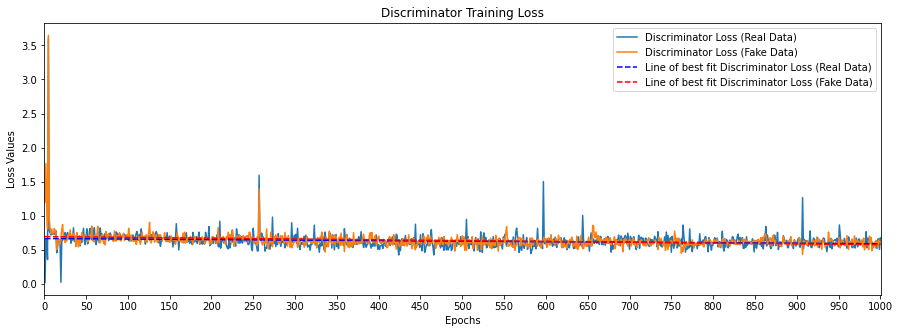

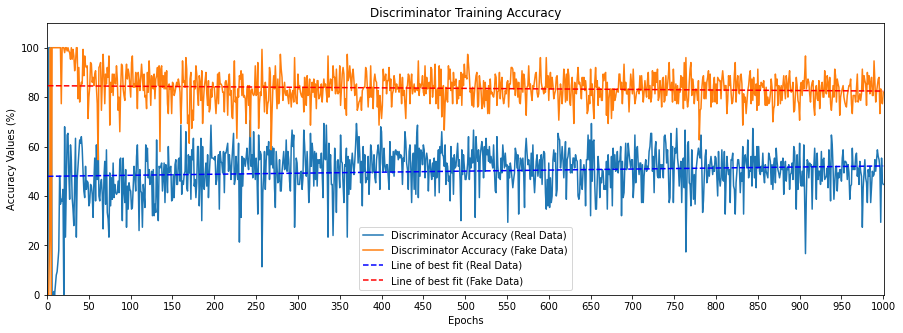

In [14]:
# Train GAN
def train_gan(generator, discriminator, gan_model, train_x, latent_dim, number_of_epochs=1000, batch_size=128):
    batches_per_epoch = int(train_x.shape[0] / batch_size)
    # Half of batch for real images and half for fake images
    half_batch_size = int(batch_size / 2)
    for i in range(number_of_epochs):
        # Loading bar for each batch in an epoch
        for j in tqdm(range(batches_per_epoch), desc='Epoch %d/%d' % (i+1, number_of_epochs)):
            # Select half_batch_size amount of random real samples from training data
            real_x, real_y = select_real_samples(train_x, half_batch_size)
            # Train discriminator on real images
            real_x = real_x.reshape(64, 15552)
            d_loss_real, _ = discriminator.train_on_batch(real_x, real_y)

            # Select half_batch_size amount of random fake samples from generated images
            fake_x, fake_y = generate_fake_samples(generator, latent_dim, half_batch_size)
            # Train discriminator on fake images
            fake_x = fake_x.reshape(64, 15552)
            d_loss_fake, _ = discriminator.train_on_batch(fake_x, fake_y)

            # Select batch_size amount of random points in the latent space
            gan_x = generate_latent_points(latent_dim, batch_size)
            # Inverted label for each image 
            gan_y = np.ones((batch_size, 1))
            # Update the generator via the discriminators erorr
            g_loss = gan_model.train_on_batch(gan_x, gan_y)
        print('Discriminator Loss (Real Data): %.3f, Discriminator Loss (Fake Data): %.3f, Generator Loss: %.3f' %
              (d_loss_real, d_loss_fake, g_loss))
        
        # Add data from each epoch to these arrays for plotting
        real_x, real_y = select_real_samples(train_x, 150)
        real_x = real_x.reshape(150, 15552)
        _, d_acc_real = discriminator.evaluate(real_x, real_y, verbose=0)

        fake_x, fake_y = generate_fake_samples(generator, latent_dim, 150)
        fake_x = fake_x.reshape(150, 15552)
        _, d_acc_fake = discriminator.evaluate(fake_x, fake_y, verbose=0)

        losses.append((d_loss_real, d_loss_fake))
        accuracies.append((100.0 * d_acc_real, 100.0 * d_acc_fake))
        epochs.append(i + 1)

        # Evaluate GAN every 10 epochs
        if (i + 1) % 10 == 0:
            save_generator(generator, i)
            evaluate_gan(i, generator, discriminator, train_x, latent_dim)

train_x = load_training_data()
train_gan(generator, discriminator, gan_model, train_x, latent_dim)
plot_loss_and_accuracy(losses, accuracies, epochs)